# Определение стоимости автомобилей

## Описание и цель проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- время предсказания.

## План исследования

- [Подготовка данных](#preparing)
- [Обучение моделей](#models_train)
- [Анализ моделей](#model_analize)
- [Вывод](#conclusion)

## Импорт необходимых библиотек и определение констант

In [1]:
# common
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#correlation
import phik

# pipeline & preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

#model selection
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)


#models
from sklearn.linear_model import (
    LinearRegression, 
    Ridge,
    Lasso
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#metrics
from sklearn.metrics import (
    root_mean_squared_error
)

from sklearn.impute import SimpleImputer


In [2]:
# constants
RANDOM_STATE = 42

## Подготовка данных <a id='preparing'>

### Загрузка и предпросмотр данных

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()    

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Видны пропуски, несоответсвие типов данных (даты), плохой стиль названий столбцов - данным нужна предобработка 

### Предобработка данных

#### Работа с именами столбцов

In [5]:
df.columns = df.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower() #rename columns using regexp
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
0  2016-03-24 11:52:17    480          NaN               1993  manual      0   
1  2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2  2016-03-14 12:52:21   9800          suv               2004    auto    163   
3  2016-03-17 16:54:04   1500        small               2001  manual     75   
4  2016-03-31 17:25:20   3600        small               2008  manual     69   

   model  kilometer  registration_month fuel_type       brand repaired  \
0   golf     150000                   0    petrol  volkswagen      NaN   
1    NaN     125000                   5  gasoline        audi      yes   
2  grand     125000                   8  gasoline        jeep      NaN   
3   golf     150000                   6    petrol  volkswagen       no   
4  fabia      90000                   7  gasoline       skoda       no   

          date_created  number_of_pictures  postal_code            last_seen  
0  2016-03-24 00:00:00                   0        70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                   0        66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                   0        90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                   0        91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                   0        60437  2016-04-06 10:17:21

#### Работа с пропусками

Посмотрим, где есть пропуски

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Начнем с модели: ее пропуск связан с какой-то ошибкой, так как машин без модели не бывает, поэтому заполним константой 

In [7]:
df['model'] = df['model'].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Далее тип кузова: попробуем поискать в датасете такие же модели и заполнить пропуски в соответствии с заполненными типами кузова

In [8]:
np.sum(df.groupby('model')['vehicle_type'].last() != df.groupby('model')['vehicle_type'].first())

84

Интресно, что некоторые автомобили бывают в разных кузовах, что логично, поэтому попробуем заполнить модой. Все же лучше, чем 10% данных выбрасывать 

Проверим пропуски:

In [9]:
df.groupby('model')['vehicle_type'].first().isna().sum()

0

In [10]:
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby('model')['vehicle_type'].transform(lambda x: x.mode()[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Далее тип коробки передач: для каждой модели он может быть любым так, что просто меняем на константу

In [11]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [12]:
df['gearbox'] = df['gearbox'].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

посмотрим на тип топлива

In [13]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Пропуски тут можно заполнить по моделям, но тут тоже одна модель может иметь множество различных типов топлива, так что заполним, как `other`, который и так есть в этом столбце

In [14]:
df['fuel_type'] = df['fuel_type'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

И, наконец, информация о том, была ли машина в ремонте или нет.

Тут пропуск несет в себе смысл - нет записи - не было ремонтов, поэтому заменим пропуски на `no`

In [15]:
df['repaired'] = df['repaired'].fillna('no')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Заполнили пропуски везде, причем для каждого из признака с пропусками было около 10% пропусков, поэтому удалять не хотелось бы 

#### Работа с типами данных

In [16]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

#### Работа с дубликатами

Посмотрим на явные дубликаты и удалим их при необходимости

In [17]:
df.duplicated().sum()

5

In [18]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Теперь посмотрим на неявные дубликаты в значениях столбцов:

In [19]:
def find_implicit_duplicates(df):
    for col in df.select_dtypes(exclude='number').columns:
        print(col)
        print(df.select_dtypes(exclude='number')[col].unique())

In [20]:
find_implicit_duplicates(df.select_dtypes(exclude='number').drop(columns=['date_crawled', 'date_created', 'last_seen']))

vehicle_type
['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']
gearbox
['manual' 'auto' 'unknown']
model
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider

Замечаем `gasoline` - `petrol` (означают бензин) в колонке  и `fuel_type` и `rangerover` - `range_rover` (одна модель) в колонке `. Избавимсяmodel`

In [21]:
df = df.replace({'gasoline': 'petrol', 'rangerover': 'range_rover'})
find_implicit_duplicates(df.select_dtypes(exclude='number').drop(columns=['date_crawled', 'date_created', 'last_seen']))

vehicle_type
['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other']
gearbox
['manual' 'auto' 'unknown']
model
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider

Теперь посмотрим на неявные дубликаты с другой стороны - попробуем исключить информацию о человеке, и о базе данных а оставить только о машине. Посмотрим:

In [22]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
0 2016-03-24 11:52:17    480        sedan               1993  manual      0   
1 2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2 2016-03-14 12:52:21   9800          suv               2004    auto    163   
3 2016-03-17 16:54:04   1500        small               2001  manual     75   
4 2016-03-31 17:25:20   3600        small               2008  manual     69   

     model  kilometer  registration_month fuel_type       brand repaired  \
0     golf     150000                   0    petrol  volkswagen       no   
1  unknown     125000                   5    petrol        audi      yes   
2    grand     125000                   8    petrol        jeep       no   
3     golf     150000                   6    petrol  volkswagen       no   
4    fabia      90000                   7    petrol       skoda       no   

  date_created  number_of_pictures  postal_code           last_seen  
0   2016-03-24                   0        70435 2016-04-07 03:16:57  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21

Оставим дату в публикации фичах, потому что от нее может зависеть цена (инфляция и т.д).

In [23]:
df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created']).duplicated().sum()

31181

In [24]:
df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created', 'price']).duplicated().sum()

111250

Если дропать таргет в том числе, то у нас 111000+ повторов. То есть в датасете есть машины с абсолютно с одинаковыми хакартеристиками, но с разной ценой. Это даже обосновано, потому что машины, которые продаются +- зачастую одинаковые (даже абсолютно), но цену каждый ставит свою (кому-то надо срочно продать, кто-то перекуп), поэтому одинаковые авто с разной ценой оставим в датасете   

In [25]:
df = df.drop_duplicates(subset=
                        df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created']).columns).\
                        reset_index(drop=True)
df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created']).duplicated().sum()

0

### Исследовательский анализ данных

In [26]:
def print_hist_box(df, bins=50):
    for col in df.columns:
        print(df[col].describe())
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    
        sns.boxplot(x=df[col], ax=ax_box)
        ax_box.set_title('Боксплот и распределение призанака ' + col)
        ax_box.set_xlabel('')
        
        plt.ylabel('Количество элементов признака ' + col)
        plt.xlabel('Значения элементов признака ' + col)
        sns.histplot(x=df[col], bins=bins, kde=True, ax=ax_hist)
    
        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
        plt.show()

In [27]:
def fmt(x): #func to determine labels on pie plot
    return '{:.1f}%\n{:.2f}'.format(x, total * x / 100)

In [28]:
def print_pie_bar(df):
    for col in df.columns:
        print(df[col].describe())
        plt.Figure(figsize=(30, 20))
        sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
        ax = sns.countplot(x=df[col], order=df[col].value_counts().index)
        for rect in ax.patches:
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.75,rect.get_height(), horizontalalignment='center', fontsize=11)
        plt.ylabel('Количество')
        plt.xlabel('Значение')
        plt.title('Столбчатая диаграмма признака ' + col)
        ax.tick_params(axis='x', labelrotation=90)
        plt.show()
        global total
        total = df[col].count()
        df[col].value_counts().plot(kind='pie', autopct=fmt)
        plt.title('Круговая диаграмма признака ' + col)
        plt.ylabel('')
        plt.show()

In [29]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
0 2016-03-24 11:52:17    480        sedan               1993  manual      0   
1 2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2 2016-03-14 12:52:21   9800          suv               2004    auto    163   
3 2016-03-17 16:54:04   1500        small               2001  manual     75   
4 2016-03-31 17:25:20   3600        small               2008  manual     69   

     model  kilometer  registration_month fuel_type       brand repaired  \
0     golf     150000                   0    petrol  volkswagen       no   
1  unknown     125000                   5    petrol        audi      yes   
2    grand     125000                   8    petrol        jeep       no   
3     golf     150000                   6    petrol  volkswagen       no   
4    fabia      90000                   7    petrol       skoda       no   

  date_created  number_of_pictures  postal_code           last_seen  
0   2016-03-24                   0        70435 2016-04-07 03:16:57  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21

count    323183.000000
mean       4409.367857
std        4523.666589
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6390.000000
max       20000.000000
Name: price, dtype: float64


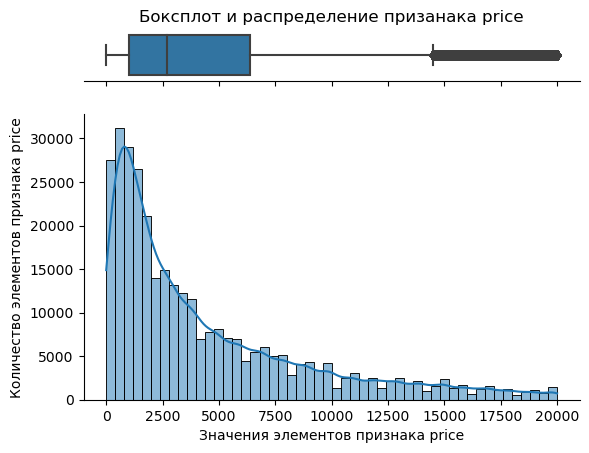

count    323183.000000
mean        110.290458
std         196.895182
min           0.000000
25%          69.000000
50%         105.000000
75%         141.000000
max       20000.000000
Name: power, dtype: float64


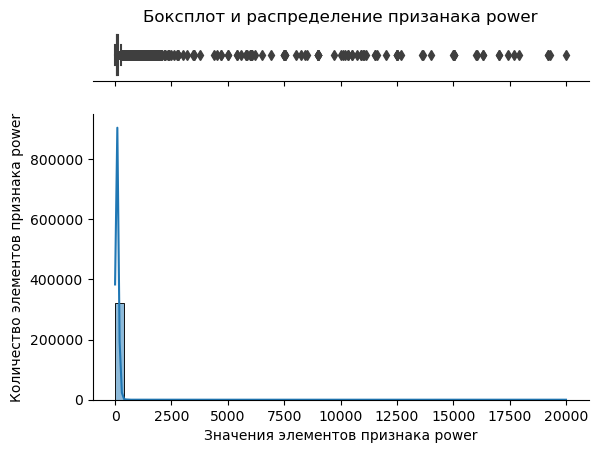

count    323183.000000
mean     128056.905840
std       38017.336057
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


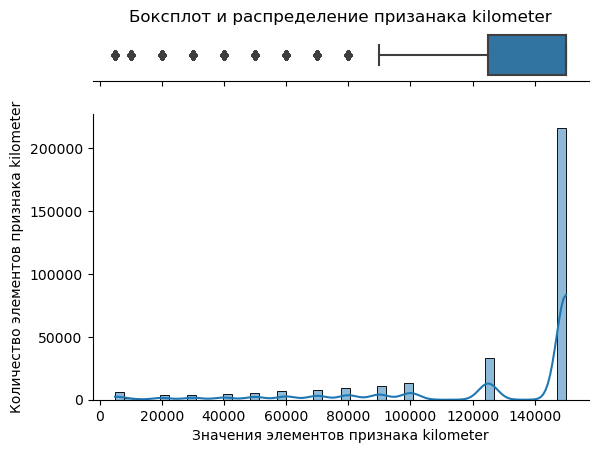

count    323183.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64


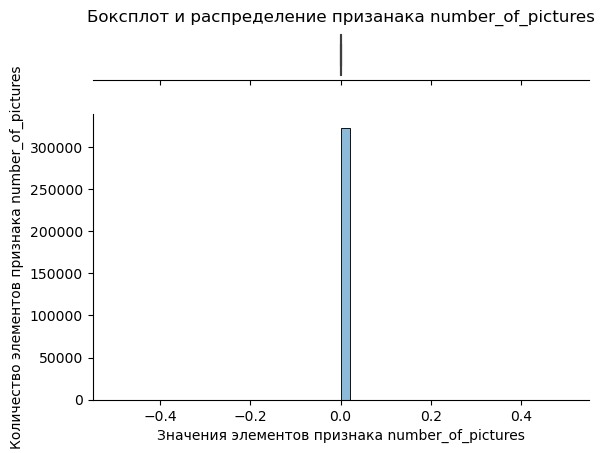

In [30]:
#year and month are categorial, postal code is non informative
print_hist_box(df.select_dtypes(include='number').drop(columns=['registration_year', 'registration_month', 'postal_code'])) 

- `price` - таргет имеет ненормальное распределение, попробуем прологарифмировать его в следющем пункте, чтоб получить нормальное, потому что кто бы что не говорил, а в задачах регрессии лучше, чтобы таргет имел нормальное распределение

In [31]:
df[df['price'] < 500]

date_crawled  price vehicle_type  registration_year  gearbox  \
0      2016-03-24 11:52:17    480        sedan               1993   manual   
7      2016-03-21 18:54:38      0        sedan               1980   manual   
15     2016-03-11 21:39:15    450        small               1910  unknown   
16     2016-04-01 12:46:46    300        small               2016  unknown   
23     2016-03-12 19:43:07    450        small               1997   manual   
...                    ...    ...          ...                ...      ...   
323142 2016-03-15 19:57:11    400        wagon               1991   manual   
323150 2016-03-30 20:55:30    350        small               1996  unknown   
323155 2016-04-04 14:41:28    390        small               1997     auto   
323156 2016-03-31 19:52:33    180        sedan               1995  unknown   
323178 2016-03-21 09:50:58      0        sedan               2005   manual   

        power    model  kilometer  registration_month fuel_type       brand  \
0           0     golf     150000                   0    petrol  volkswagen   
7          50    other      40000                   7    petrol  volkswagen   
15          0       ka       5000                   0    petrol        ford   
16         60     polo     150000                   0    petrol  volkswagen   
23         50    arosa     150000                   5    petrol        seat   
...       ...      ...        ...                 ...       ...         ...   
323142      0   legacy     150000                   0    petrol      subaru   
323150     65    punto     150000                   0     other        fiat   
323155      0    corsa     100000                   6    petrol        opel   
323156      0  unknown     125000                   3    petrol        opel   
323178      0     colt     150000                   7    petrol  mitsubishi   

       repaired date_created  number_of_pictures  postal_code  \
0            no   2016-03-24                   0        70435   
7            no   2016-03-21                   0        19348   
15           no   2016-03-11                   0        24148   
16           no   2016-04-01                   0        38871   
23           no   2016-03-12                   0         9526   
...         ...          ...                 ...          ...   
323142       no   2016-03-15                   0        24558   
323150       no   2016-03-30                   0        25436   
323155      yes   2016-04-04                   0        17509   
323156       no   2016-03-31                   0        41470   
323178      yes   2016-03-21                   0         2694   

                 last_seen  
0      2016-04-07 03:16:57  
7      2016-03-25 16:47:58  
15     2016-03-19 08:46:47  
16     2016-04-01 12:46:46  
23     2016-03-21 01:46:11  
...                    ...  
323142 2016-03-19 15:49:00  
323150 2016-04-07 13:50:41  
323155 2016-04-06 15:46:11  
323156 2016-04-06 14:18:04  
323178 2016-03-21 10:42:49  

[33208 rows x 16 columns]

Тут придется удалить  34000+ строк :( потому что как ни крути, а это либо объявления с ошибкой, либо как-то странно проданные автомобили, но восстановить цену точно не получится. Даже если это и реальные цены по каким то причинам, то эти причины в датасете, как правило, не указаны, так что эти машины будут вносить сильный шум. А так как это таргет, то и экспериментировать со вставкой среднего вместо 0 и т.д. не стоит. Теряем примерно 9.5 % данных. То же самое можно сказть и про аномально высокие цены машины, но, просмотрев их, я увидел там бмв, форд мустанг и так далее. Иногда проскакивают конечно и выбросы, но все таки все машины с высокой ценой удалять думаю не стоит, несмотря на некоторые выбросы, хотя на 2016 год 20 000 евро это 1,5 млн. руб, так что их не трогаем

In [32]:
df = df.drop(df[df['price'] < 500].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289975 entries, 1 to 323182
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        289975 non-null  datetime64[ns]
 1   price               289975 non-null  int64         
 2   vehicle_type        289975 non-null  object        
 3   registration_year   289975 non-null  int64         
 4   gearbox             289975 non-null  object        
 5   power               289975 non-null  int64         
 6   model               289975 non-null  object        
 7   kilometer           289975 non-null  int64         
 8   registration_month  289975 non-null  int64         
 9   fuel_type           289975 non-null  object        
 10  brand               289975 non-null  object        
 11  repaired            289975 non-null  object        
 12  date_created        289975 non-null  datetime64[ns]
 13  number_of_pictures  289975 non-nul

count    289975.000000
mean       4891.624237
std        4532.157376
min         500.000000
25%        1490.000000
50%        3200.000000
75%        6950.000000
max       20000.000000
Name: price, dtype: float64


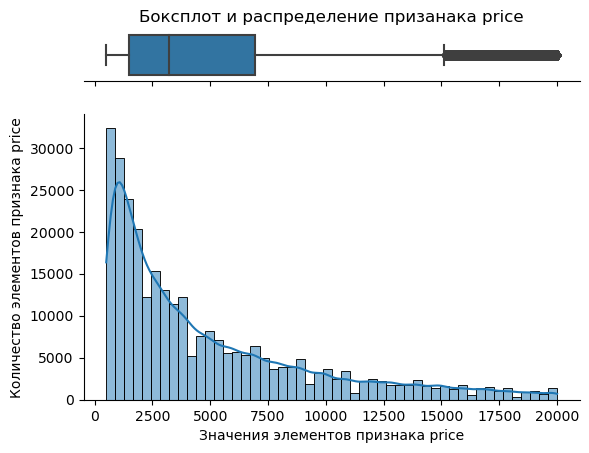

In [33]:
print_hist_box(df['price'].to_frame())

- `power` - мощность в л.с. Видны явные выбросы. Посмотрим на них

In [34]:
df[(df['power'] > 500) & (df['power'] < 1000)].head(10)

date_crawled  price vehicle_type  registration_year gearbox  \
4052  2016-04-03 20:31:00   3100        sedan               2005  manual   
6278  2016-03-31 23:50:47    599        small               2002  manual   
6482  2016-03-14 15:54:34   3000        small               2009  manual   
6615  2016-03-31 19:48:22    600        small               1996  manual   
8026  2016-03-15 13:49:25    500        small               2002  manual   
12668 2016-03-09 18:43:44   3500  convertible               2003  manual   
13294 2016-03-31 12:38:14  18500        small               2002    auto   
14460 2016-03-12 09:55:06    599        small               2018  manual   
17374 2016-03-23 18:59:00  15500        coupe               2009    auto   
19957 2016-03-21 10:37:15  18500          suv               2006    auto   

       power    model  kilometer  registration_month fuel_type       brand  \
4052     953     colt     150000                   4    petrol  mitsubishi   
6278     603    matiz       5000                  11    petrol   chevrolet   
6482     771    punto     125000                   0    petrol        fiat   
6615     603    corsa     150000                   8    petrol        opel   
8026     620  ypsilon     150000                  12    petrol      lancia   
12668    952       ka      70000                   5    petrol        ford   
13294    600   s_type     150000                  12     other      jaguar   
14460    599   twingo     150000                   0     other     renault   
17374    507  m_reihe     150000                   1    petrol         bmw   
19957    521  cayenne     150000                   5    petrol     porsche   

      repaired date_created  number_of_pictures  postal_code  \
4052        no   2016-04-03                   0        60326   
6278       yes   2016-03-31                   0        44379   
6482        no   2016-03-14                   0        40721   
6615       yes   2016-03-31                   0        70327   
8026        no   2016-03-15                   0        55566   
12668       no   2016-03-09                   0        26903   
13294       no   2016-03-31                   0        13595   
14460       no   2016-03-12                   0        47138   
17374      yes   2016-03-23                   0        74254   
19957       no   2016-03-21                   0        24939   

                last_seen  
4052  2016-04-07 14:56:46  
6278  2016-04-01 03:41:52  
6482  2016-03-14 15:54:34  
6615  2016-04-06 14:17:51  
8026  2016-04-06 03:15:27  
12668 2016-03-12 04:16:07  
13294 2016-04-06 04:46:34  
14460 2016-04-06 01:45:44  
17374 2016-03-31 07:44:43  
19957 2016-04-06 03:16:48

In [35]:
df[df['power'] > 10000].head(10)

date_crawled  price vehicle_type  registration_year gearbox  \
24963 2016-03-28 19:57:39  10900          bus               2009  manual   
44290 2016-04-07 07:36:38  15800  convertible               2014    auto   
55808 2016-04-01 21:55:58   1995        wagon               2002  manual   
61606 2016-03-27 18:47:59   2200        small               1999  manual   
62572 2016-03-28 11:49:56   3250        sedan               2001    auto   
75819 2016-03-25 13:36:57    850        sedan               2000  manual   
82494 2016-03-28 10:49:33   1999        sedan               1991    auto   
93449 2016-03-16 13:46:18   1380  convertible               2001    auto   
93653 2016-03-12 10:36:18   4700          bus               1997  manual   
95559 2016-03-31 18:54:51   5500        wagon               2010  manual   

       power        model  kilometer  registration_month fuel_type  \
24963  10520        caddy     150000                   6    petrol   
44290  10218       fortwo      30000                   3    petrol   
55808  11530        focus     150000                   1    petrol   
61606  12012         polo     150000                   3    petrol   
62572  17932        omega     150000                   6    petrol   
75819  12510        astra      30000                  10     other   
82494  10912      unknown     150000                   0    petrol   
93449  10710       megane     150000                  10     other   
93653  10522  transporter     150000                   0    petrol   
95559  11509         ceed     150000                   9     other   

               brand repaired date_created  number_of_pictures  postal_code  \
24963     volkswagen       no   2016-03-28                   0        36272   
44290          smart       no   2016-04-06                   0        81373   
55808           ford       no   2016-04-01                   0        35759   
61606     volkswagen       no   2016-03-27                   0         9526   
62572           opel       no   2016-03-28                   0        86641   
75819           opel       no   2016-03-25                   0        23611   
82494  mercedes_benz       no   2016-03-28                   0        88069   
93449        renault       no   2016-03-16                   0        71282   
93653     volkswagen       no   2016-03-12                   0        87437   
95559            kia       no   2016-03-31                   0        15907   

                last_seen  
24963 2016-04-07 02:47:02  
44290 2016-04-07 07:36:38  
55808 2016-04-05 14:44:36  
61606 2016-04-01 19:44:55  
62572 2016-04-06 14:17:21  
75819 2016-03-31 20:45:39  
82494 2016-03-30 01:15:32  
93449 2016-03-19 10:45:58  
93653 2016-03-12 10:36:18  
95559 2016-04-06 13:15:34

можем поправить выбросы сократив порядок больших, но некоторые модели и правда не являются выбросами - например порш кайен с 500+ л.с. вполне нормальная практика. Поэтому чтоб потерять минимум информации сначала заменим на таких выбивающихся моделях этот показатель на медианный по модели (среднее будет смещено как раз из-за выбросов) 

In [36]:
df.loc[df['power'] < 10, 'power'] = df.groupby('model')['power'].transform('median')
df[df['power'] < 10]

date_crawled  price vehicle_type  registration_year gearbox  \
219458 2016-03-30 11:39:08   3800        wagon               1978  manual   

        power    model  kilometer  registration_month fuel_type       brand  \
219458    0.0  serie_1      30000                   0    petrol  land_rover   

       repaired date_created  number_of_pictures  postal_code  \
219458       no   2016-03-30                   0        49824   

                 last_seen  
219458 2016-03-30 11:39:08

In [37]:
df.loc[df['power'] > 500, 'power'] = df.groupby('model')['power'].transform('median')
df[df['power'] > 500]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

count    289975.000000
mean        121.013531
std          52.361346
min           0.000000
25%          82.000000
50%         111.000000
75%         150.000000
max         500.000000
Name: power, dtype: float64


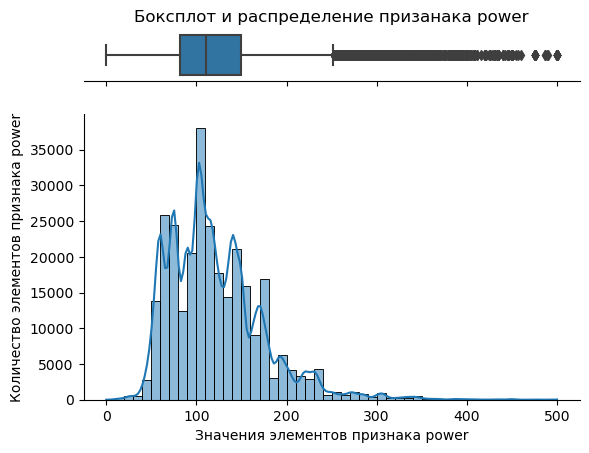

In [38]:
print_hist_box(df['power'].to_frame())

У нас есть одно редкое авто, так еще и с ошибкой. Удаляем его

In [39]:
df.loc[df['power'] < 10].head(10)

date_crawled  price vehicle_type  registration_year gearbox  \
219458 2016-03-30 11:39:08   3800        wagon               1978  manual   

        power    model  kilometer  registration_month fuel_type       brand  \
219458    0.0  serie_1      30000                   0    petrol  land_rover   

       repaired date_created  number_of_pictures  postal_code  \
219458       no   2016-03-30                   0        49824   

                 last_seen  
219458 2016-03-30 11:39:08

In [40]:
df = df.drop(df[df['power'] < 10].index)
df[df['power'] < 10]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

count    289974.000000
mean        121.013949
std          52.360954
min          10.000000
25%          82.000000
50%         111.000000
75%         150.000000
max         500.000000
Name: power, dtype: float64


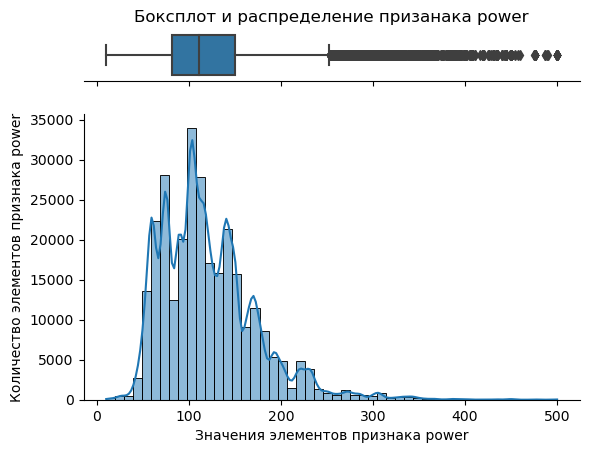

In [41]:
print_hist_box(df['power'].to_frame())

Оставшиеся выбросы не являются аномалиями, так что оставить можно

- `kilometer` - пробег - распределение не являтся нормальным, причем больше, чем у половины машин пробег строго равен 150 000. В целом действительности может соответствовать, но значение, по-видимому, округленное. Выбросы аномалиями не являются, так что оставляем

И ни для одной машины не указыно ни одной фотографии, так что этот признак можно убать, полную работу с фичами произведем на 3 шаге

In [42]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
1 2016-03-24 10:58:45  18300        coupe               2011  manual  190.0   
2 2016-03-14 12:52:21   9800          suv               2004    auto  163.0   
3 2016-03-17 16:54:04   1500        small               2001  manual   75.0   
4 2016-03-31 17:25:20   3600        small               2008  manual   69.0   
5 2016-04-04 17:36:23    650        sedan               1995  manual  102.0   

     model  kilometer  registration_month fuel_type       brand repaired  \
1  unknown     125000                   5    petrol        audi      yes   
2    grand     125000                   8    petrol        jeep       no   
3     golf     150000                   6    petrol  volkswagen       no   
4    fabia      90000                   7    petrol       skoda       no   
5      3er     150000                  10    petrol         bmw      yes   

  date_created  number_of_pictures  postal_code           last_seen  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21  
5   2016-04-04                   0        33775 2016-04-06 19:17:07

Посмотрим на даты публикации объявлений. Это нам нужно для последющего анализа

In [43]:
sorted(df['date_created'].unique())

[Timestamp('2014-03-10 00:00:00'),
 Timestamp('2015-03-20 00:00:00'),
 Timestamp('2015-06-18 00:00:00'),
 Timestamp('2015-08-07 00:00:00'),
 Timestamp('2015-08-10 00:00:00'),
 Timestamp('2015-09-04 00:00:00'),
 Timestamp('2015-09-09 00:00:00'),
 Timestamp('2015-11-02 00:00:00'),
 Timestamp('2015-11-08 00:00:00'),
 Timestamp('2015-11-10 00:00:00'),
 Timestamp('2015-11-12 00:00:00'),
 Timestamp('2015-11-17 00:00:00'),
 Timestamp('2015-11-23 00:00:00'),
 Timestamp('2015-11-24 00:00:00'),
 Timestamp('2015-12-05 00:00:00'),
 Timestamp('2015-12-06 00:00:00'),
 Timestamp('2015-12-17 00:00:00'),
 Timestamp('2015-12-27 00:00:00'),
 Timestamp('2015-12-30 00:00:00'),
 Timestamp('2016-01-02 00:00:00'),
 Timestamp('2016-01-03 00:00:00'),
 Timestamp('2016-01-06 00:00:00'),
 Timestamp('2016-01-07 00:00:00'),
 Timestamp('2016-01-08 00:00:00'),
 Timestamp('2016-01-10 00:00:00'),
 Timestamp('2016-01-13 00:00:00'),
 Timestamp('2016-01-15 00:00:00'),
 Timestamp('2016-01-16 00:00:00'),
 Timestamp('2016-01-

видим объявления с марта 2014 по апрель 2016

count     289974
unique         8
top        sedan
freq       91340
Name: vehicle_type, dtype: object


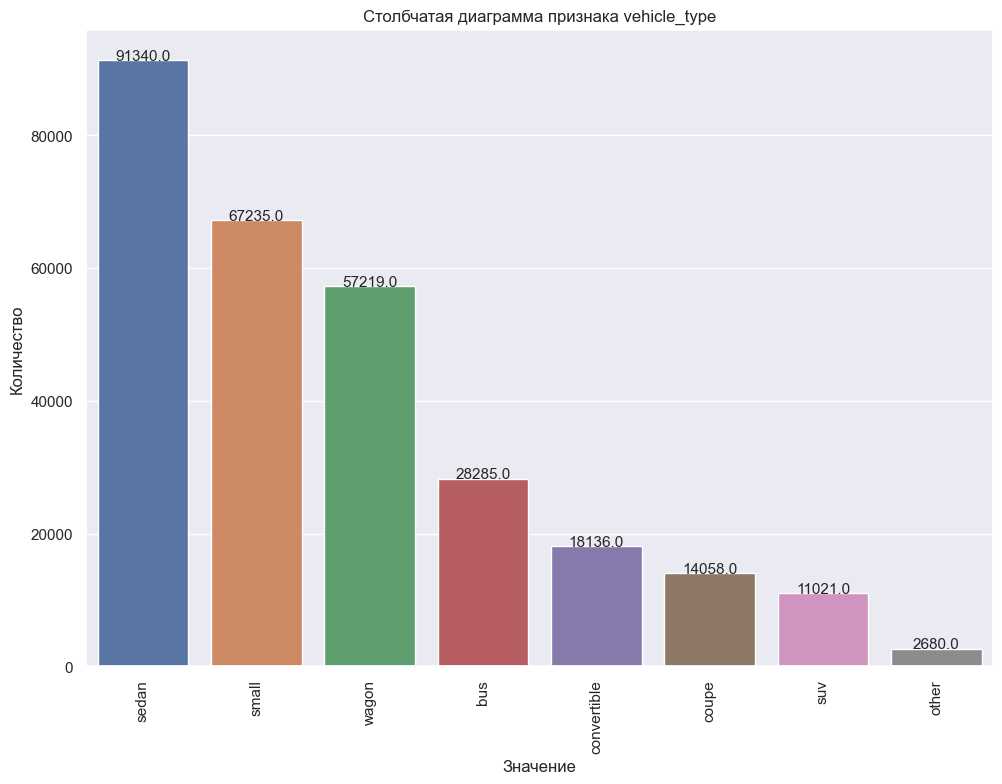

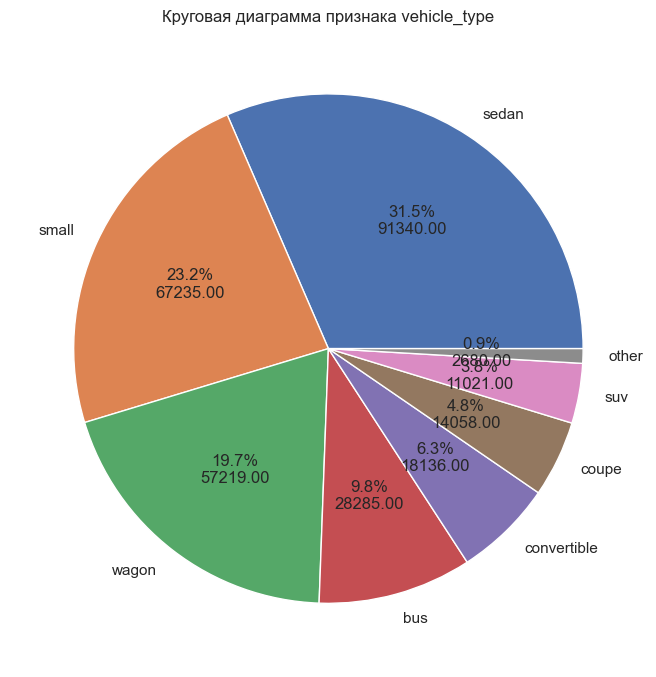

count    289974.000000
mean       2004.184858
std          67.681186
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


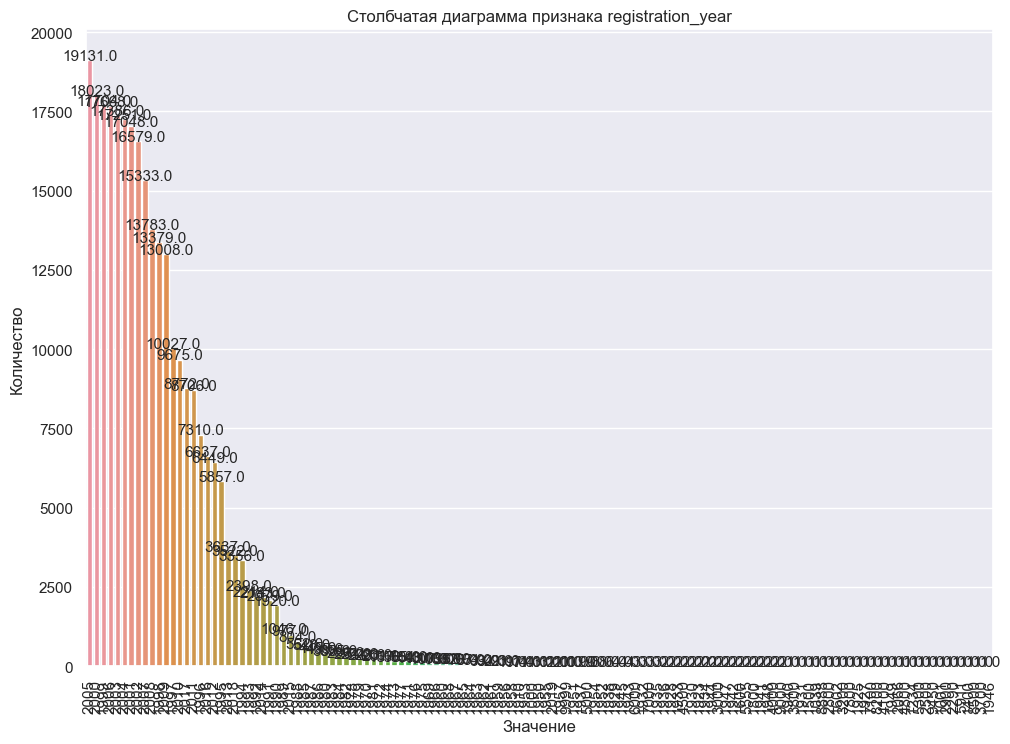

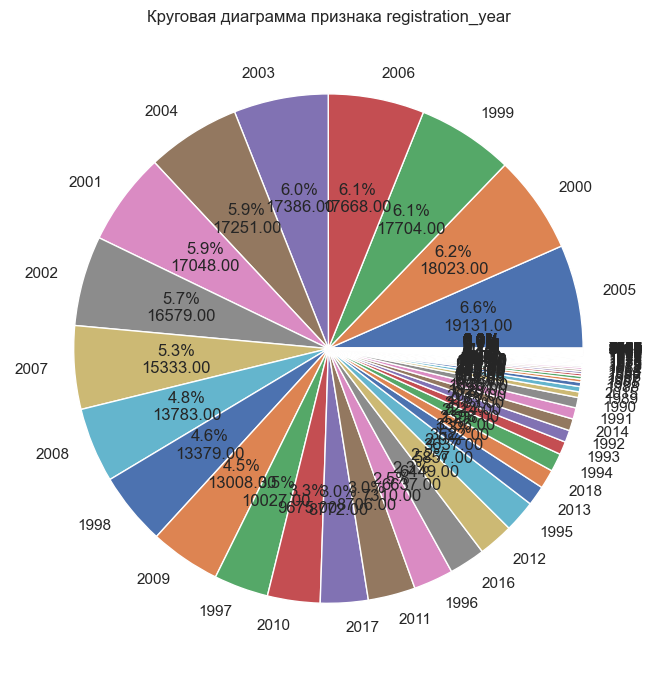

count     289974
unique         3
top       manual
freq      220183
Name: gearbox, dtype: object


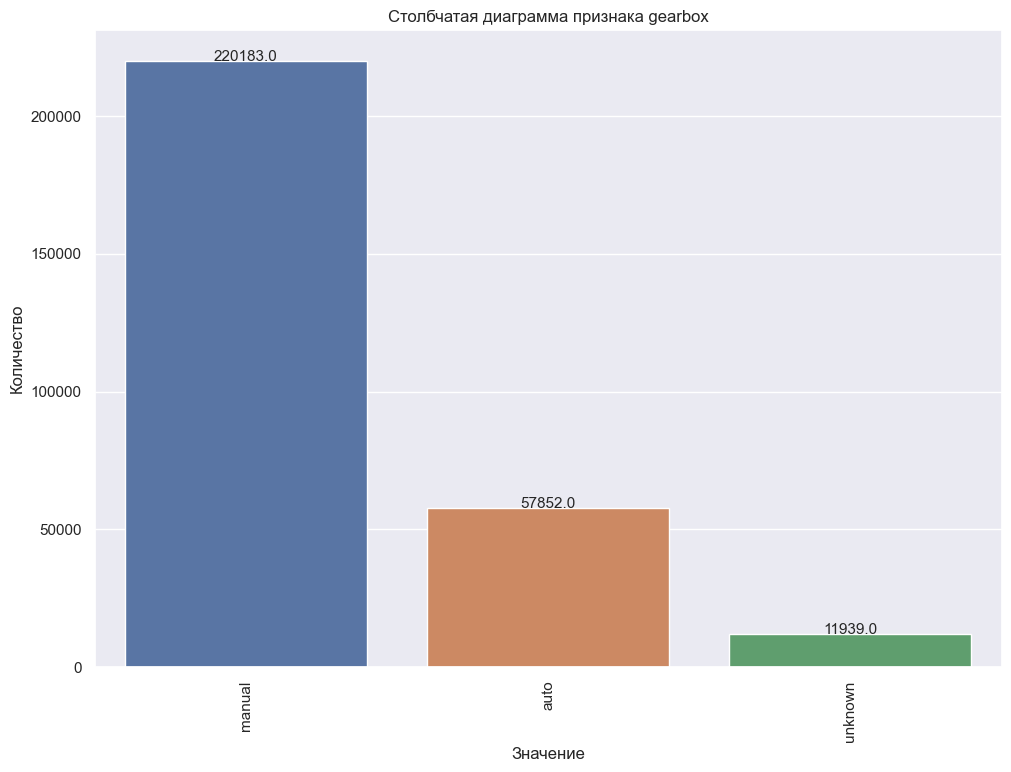

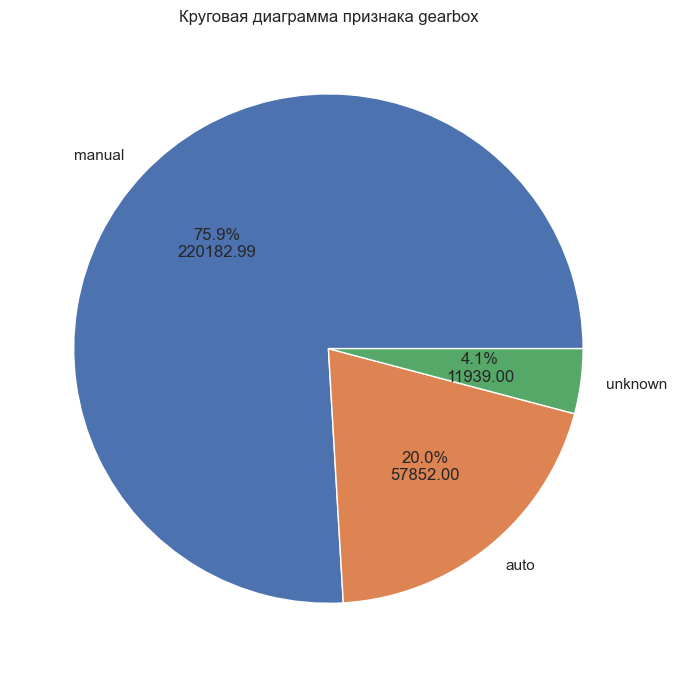

count     289974
unique       249
top         golf
freq       23364
Name: model, dtype: object


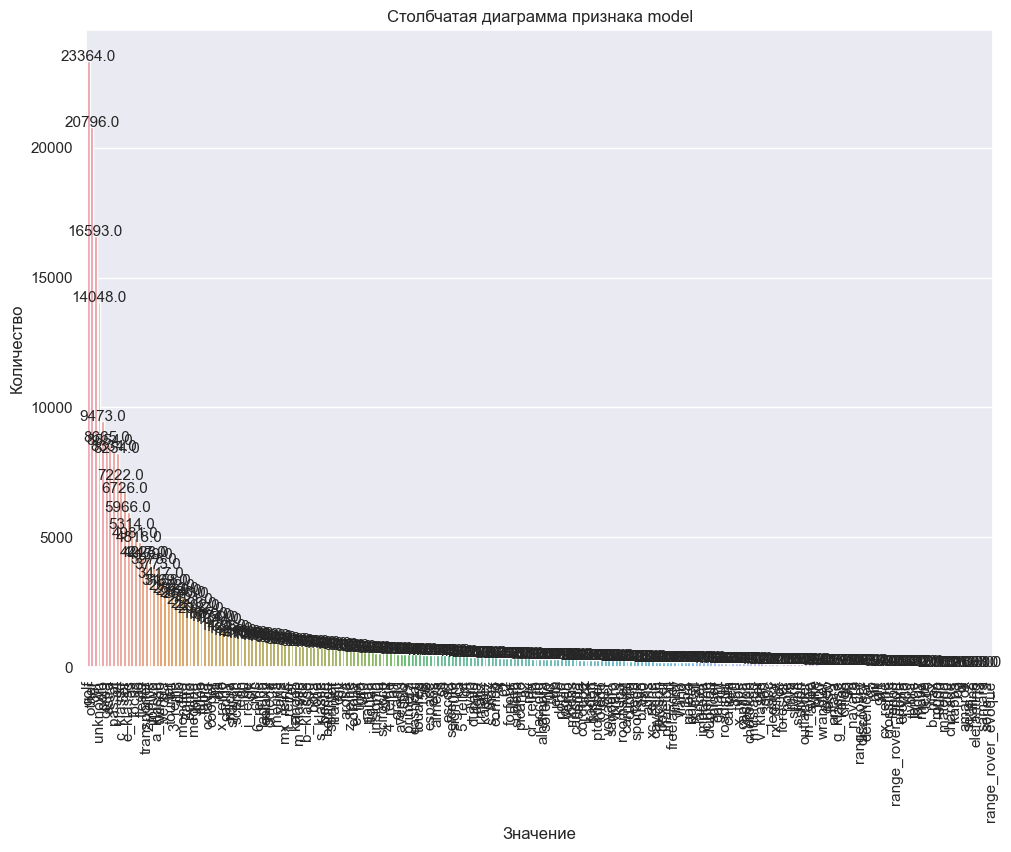

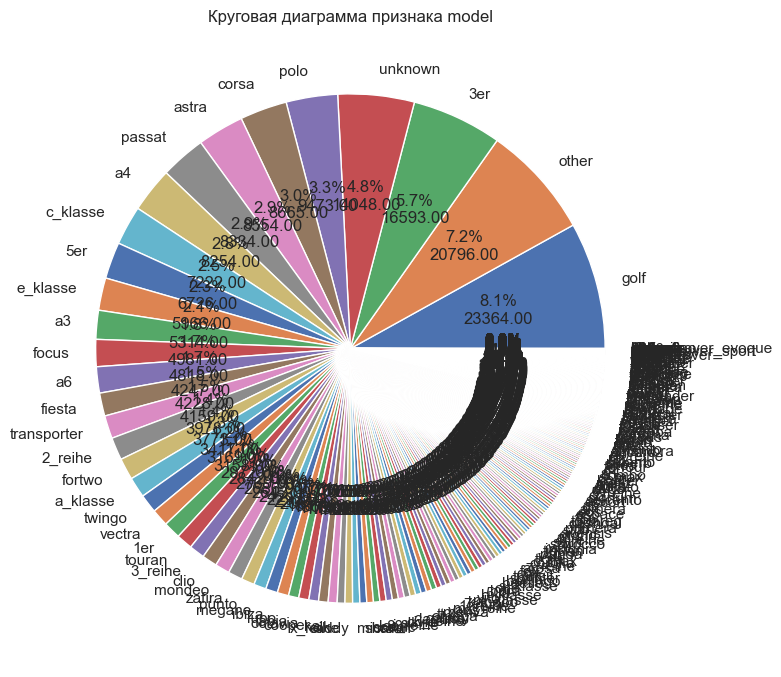

count    289974.000000
mean          5.880065
std           3.648074
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


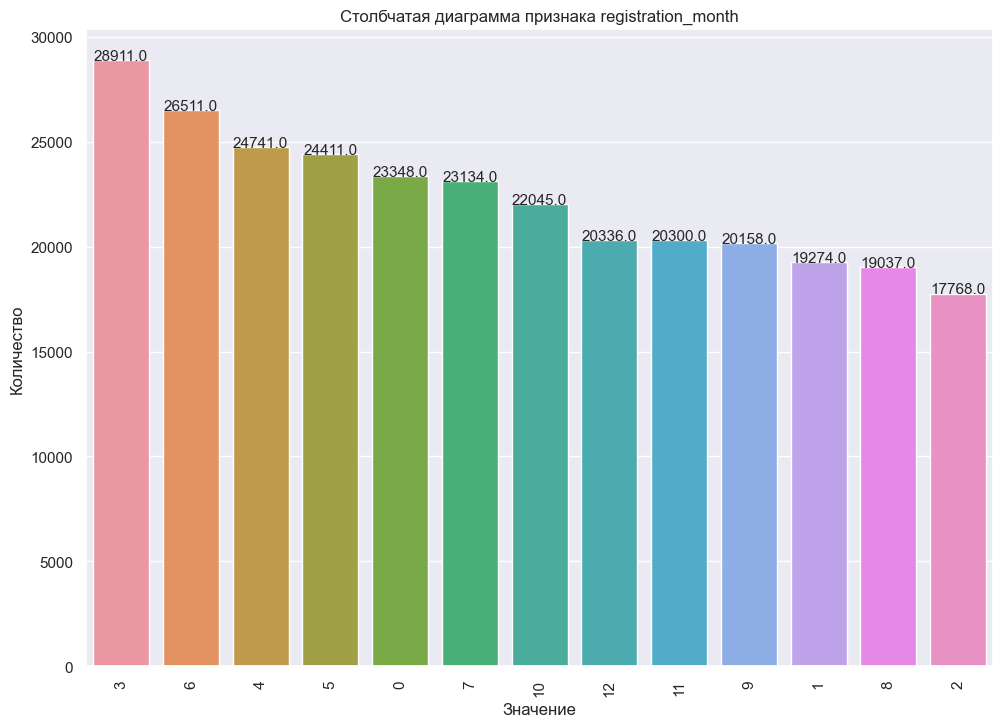

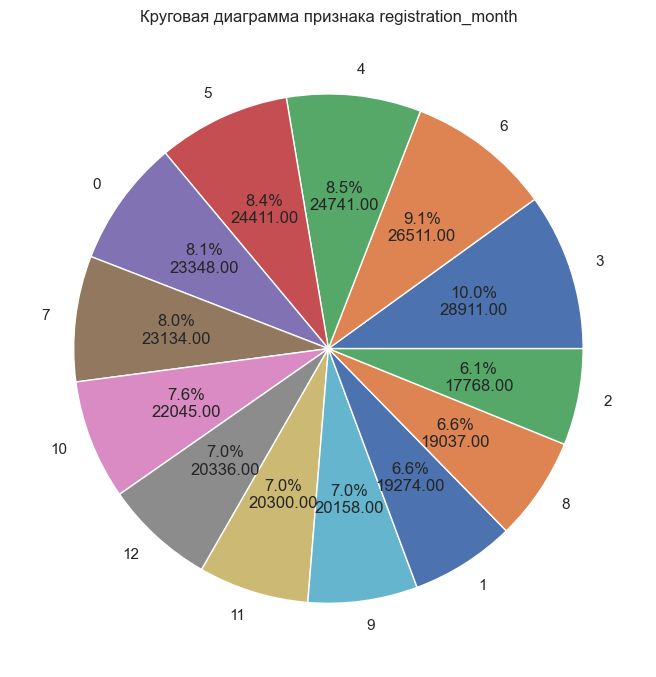

count     289974
unique         6
top       petrol
freq      261973
Name: fuel_type, dtype: object


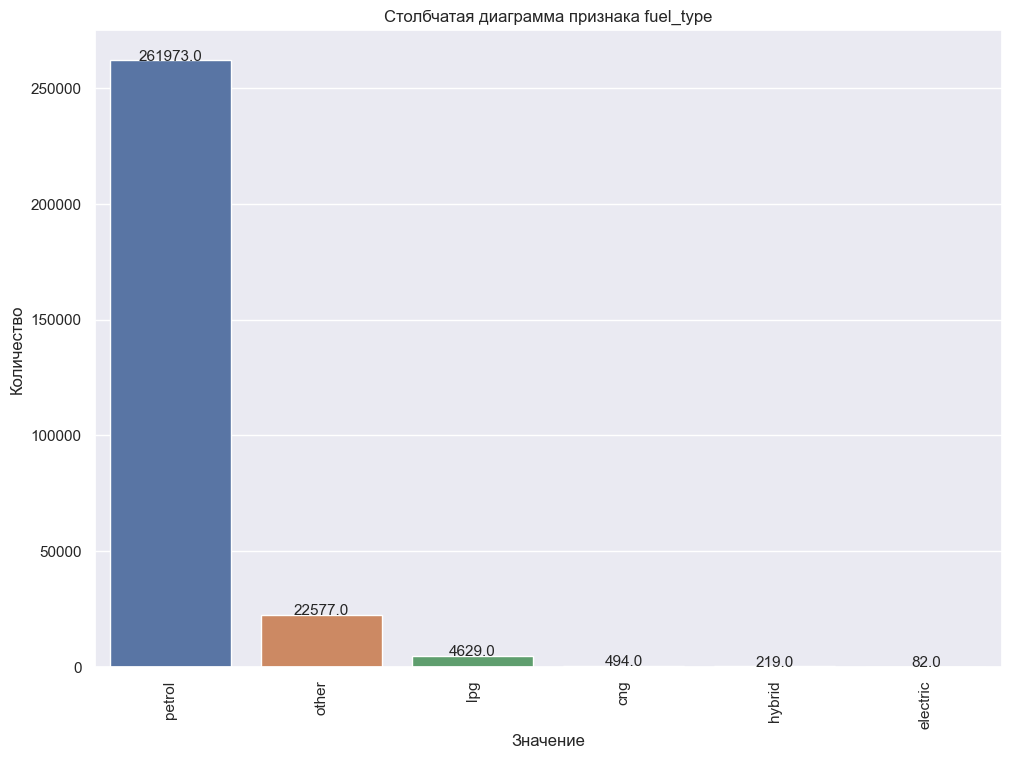

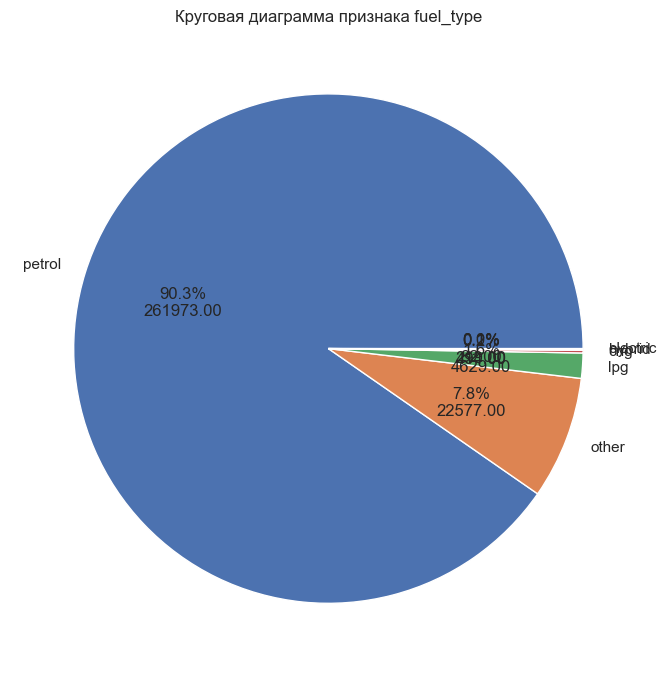

count         289974
unique            40
top       volkswagen
freq           61814
Name: brand, dtype: object


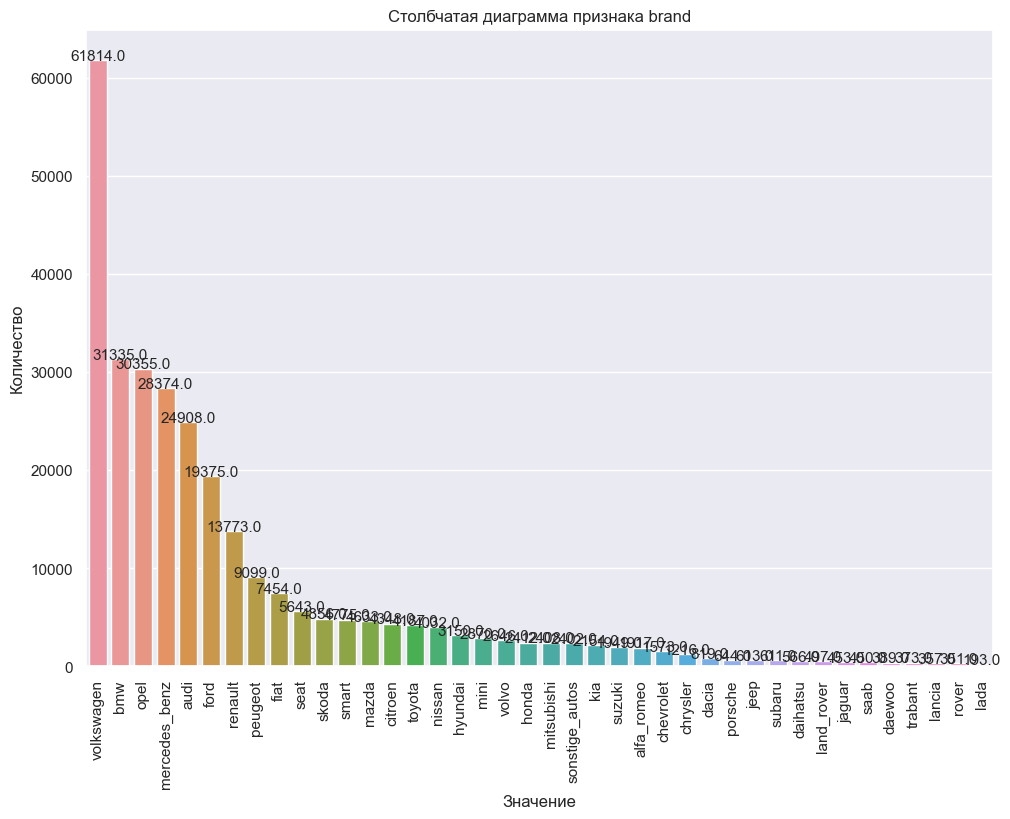

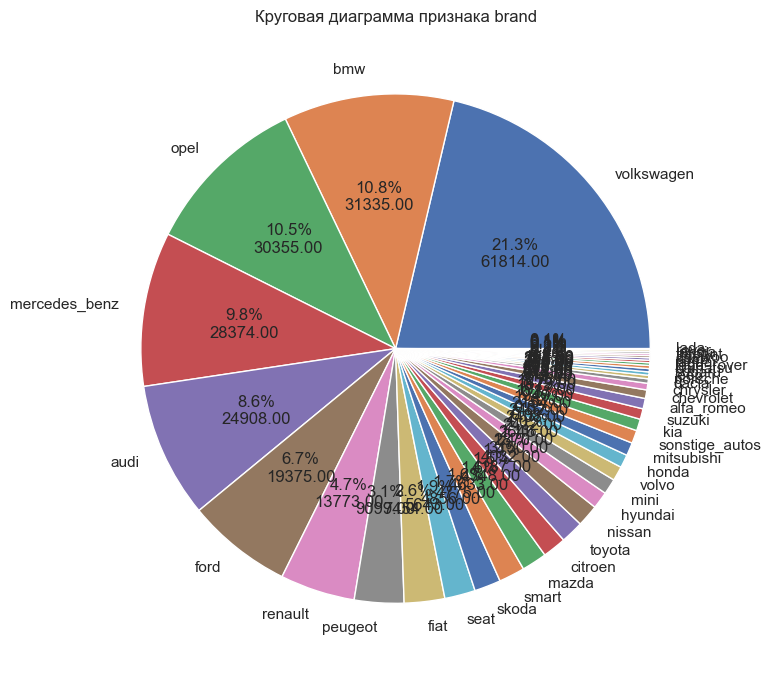

count     289974
unique         2
top           no
freq      264826
Name: repaired, dtype: object


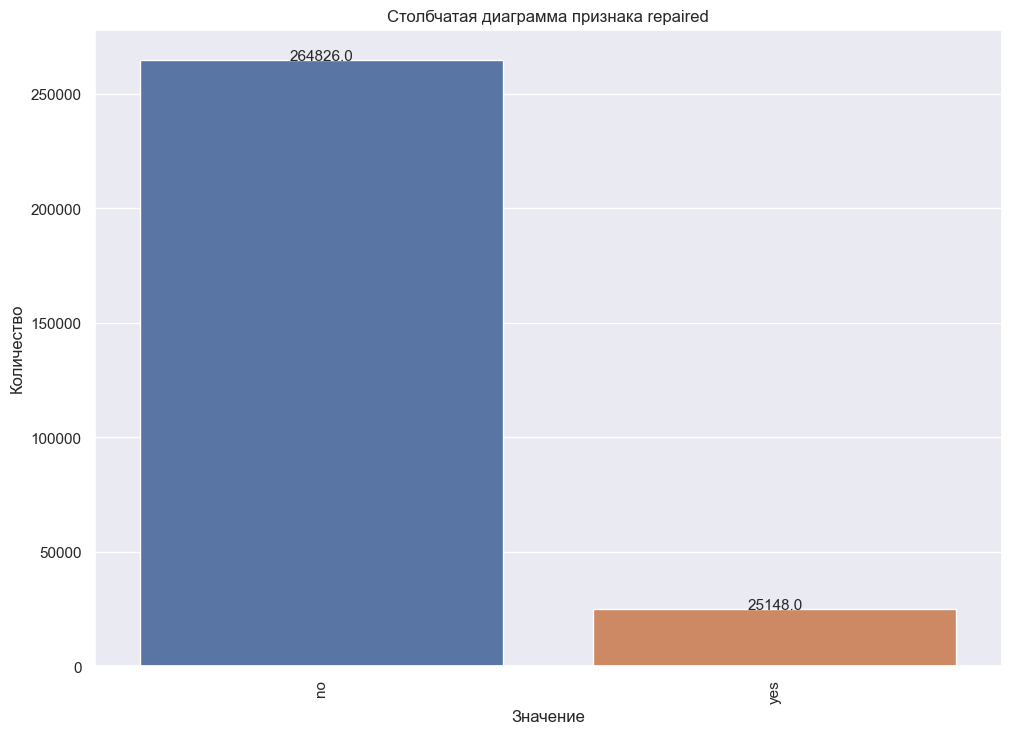

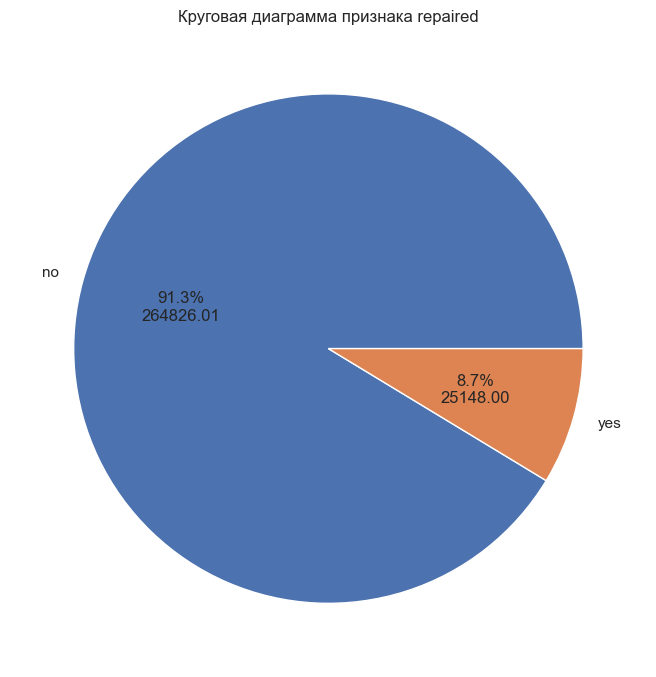

In [44]:
print_pie_bar(df[['vehicle_type', 'registration_year', 'gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'repaired']])

Интересная картина в некоторых местах. Пойдем разбираться по одному:
- с типом кузова все хорошо, сюрпризов нет

Далее год регистрации - год регистрации (и месяц) не может быть больше года и месяца даты публикации, потому что мы же не можем продавать машину, которую зарегистрировали в будующем - поэтому сменим для таких автомобилей год и месяц на дату публикации (может какие-то перекупы, сегодня купили, помыли, и тут же перепродают)=)

In [45]:
df[df['registration_year'] > 2016]

date_crawled  price vehicle_type  registration_year  gearbox  \
22     2016-03-23 14:52:51   2900          bus               2018   manual   
26     2016-03-10 19:38:18   5555        sedan               2017   manual   
48     2016-03-25 14:40:12   7750        sedan               2017   manual   
51     2016-03-07 18:57:08   2000        small               2017   manual   
57     2016-03-10 20:53:19   2399        sedan               2018   manual   
...                    ...    ...          ...                ...      ...   
322975 2016-03-11 15:49:51   3600          bus               2017   manual   
322998 2016-03-29 16:47:29   1000        wagon               2017   manual   
323046 2016-03-17 00:56:26   2140        small               2018   manual   
323090 2016-03-25 09:37:59   1250        small               2018  unknown   
323119 2016-03-05 14:55:29   5000        sedan               2017   manual   

        power    model  kilometer  registration_month fuel_type       brand  \
22       90.0   meriva     150000                   5    petrol        opel   
26      125.0       c4     125000                   4     other     citroen   
48       80.0     golf     100000                   1    petrol  volkswagen   
51       90.0    punto     150000                  11    petrol        fiat   
57       64.0    other     125000                   3     other        seat   
...       ...      ...        ...                 ...       ...         ...   
322975   86.0  transit     150000                   5    petrol        ford   
322998  101.0       a4     150000                   9     other        audi   
323046   80.0   fiesta     150000                   6     other        ford   
323090   60.0    corsa     150000                   0    petrol        opel   
323119  120.0    other     150000                   7     other     citroen   

       repaired date_created  number_of_pictures  postal_code  \
22           no   2016-03-23                   0        49716   
26           no   2016-03-10                   0        31139   
48           no   2016-03-25                   0        48499   
51          yes   2016-03-07                   0        66115   
57           no   2016-03-10                   0        33397   
...         ...          ...                 ...          ...   
322975       no   2016-03-11                   0        32339   
322998       no   2016-03-29                   0        38315   
323046       no   2016-03-17                   0        44866   
323090       no   2016-03-25                   0        45527   
323119      yes   2016-03-05                   0        15518   

                 last_seen  
22     2016-03-31 01:16:33  
26     2016-03-16 09:16:46  
48     2016-03-31 21:47:44  
51     2016-03-07 18:57:08  
57     2016-03-25 10:17:37  
...                    ...  
322975 2016-03-12 05:45:02  
322998 2016-04-06 02:44:27  
323046 2016-03-29 15:45:04  
323090 2016-04-06 07:46:13  
323119 2016-04-05 11:48:09  

[12360 rows x 16 columns]

In [46]:
df['registration_year'] = df.apply(lambda x: x['date_created'].year 
                                       if x['registration_year'] > x['date_created'].year
                                       else x['registration_year'], axis=1)
df[df['registration_year'] > df['date_created'].dt.year]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

In [47]:
df[df['registration_year'] < 1960]

date_crawled  price vehicle_type  registration_year  gearbox  \
1925   2016-03-25 15:58:21   7000          suv               1945   manual   
2270   2016-03-15 21:44:32   1800  convertible               1925  unknown   
3329   2016-03-15 21:36:20  10500        sedan               1955   manual   
10133  2016-03-27 13:59:08   1250        sedan               1910  unknown   
12919  2016-03-07 14:38:00  11000        other               1955   manual   
...                    ...    ...          ...                ...      ...   
320483 2016-03-27 20:45:09  17500        sedan               1954   manual   
320577 2016-03-09 21:56:01   5500          bus               1956   manual   
320911 2016-03-12 00:57:39  11500        sedan               1800  unknown   
322480 2016-03-16 21:56:55   6000        sedan               1937   manual   
323141 2016-03-07 19:58:44   3300        coupe               1957   manual   

        power    model  kilometer  registration_month fuel_type  \
1925     48.0    other     150000                   2    petrol   
2270     90.0  unknown       5000                   1     other   
3329     30.0    other      60000                   0    petrol   
10133   111.0    other       5000                   0     other   
12919    40.0  unknown      50000                   1    petrol   
...       ...      ...        ...                 ...       ...   
320483   52.0    other      20000                   7    petrol   
320577   37.0  unknown      60000                   4    petrol   
320911   16.0    other       5000                   6    petrol   
322480   38.0    other       5000                   0    petrol   
323141   40.0    other     100000                  11    petrol   

                 brand repaired date_created  number_of_pictures  postal_code  \
1925        volkswagen       no   2016-03-25                   0        58135   
2270    sonstige_autos       no   2016-03-15                   0        79288   
3329              ford       no   2016-03-15                   0        53498   
10133             audi       no   2016-03-27                   0        18445   
12919   sonstige_autos       no   2016-03-07                   0        59556   
...                ...      ...          ...                 ...          ...   
320483         citroen       no   2016-03-27                   0        55270   
320577  sonstige_autos       no   2016-03-09                   0         1900   
320911            fiat       no   2016-03-11                   0        16515   
322480   mercedes_benz       no   2016-03-16                   0        23936   
323141         trabant       no   2016-03-07                   0        10317   

                 last_seen  
1925   2016-03-25 15:58:21  
2270   2016-04-07 05:15:34  
3329   2016-04-07 08:16:11  
10133  2016-04-07 10:45:31  
12919  2016-03-14 06:44:36  
...                    ...  
320483 2016-04-05 18:47:03  
320577 2016-04-06 02:17:54  
320911 2016-04-05 19:47:27  
322480 2016-03-30 18:47:41  
323141 2016-03-08 06:45:48  

[259 rows x 16 columns]

И откинем соответственно совсем древние автомобили, а вернее ошибочно древние, 300 строк - просто удалим

In [48]:
df = df.drop(df[df['registration_year'] < 1960].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289715 entries, 1 to 323182
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        289715 non-null  datetime64[ns]
 1   price               289715 non-null  int64         
 2   vehicle_type        289715 non-null  object        
 3   registration_year   289715 non-null  int64         
 4   gearbox             289715 non-null  object        
 5   power               289715 non-null  float64       
 6   model               289715 non-null  object        
 7   kilometer           289715 non-null  int64         
 8   registration_month  289715 non-null  int64         
 9   fuel_type           289715 non-null  object        
 10  brand               289715 non-null  object        
 11  repaired            289715 non-null  object        
 12  date_created        289715 non-null  datetime64[ns]
 13  number_of_pictures  289715 non-nul

Проделаем то же самое теперь по месяцам

In [49]:
df[(df['registration_year'] == df['date_created'].dt.year) & (df['date_created'].dt.month < df['registration_month'])]

date_crawled  price vehicle_type  registration_year gearbox  \
22     2016-03-23 14:52:51   2900          bus               2016  manual   
26     2016-03-10 19:38:18   5555        sedan               2016  manual   
31     2016-03-29 16:57:02    899        small               2016  manual   
51     2016-03-07 18:57:08   2000        small               2016  manual   
155    2016-03-09 12:53:53  14500          suv               2016  manual   
...                    ...    ...          ...                ...     ...   
323017 2016-03-29 19:50:03   3000        sedan               2016  manual   
323042 2016-03-10 23:36:19   1350        coupe               2016  manual   
323046 2016-03-17 00:56:26   2140        small               2016  manual   
323119 2016-03-05 14:55:29   5000        sedan               2016  manual   
323176 2016-03-09 13:37:43   5250        wagon               2016    auto   

        power     model  kilometer  registration_month fuel_type  \
22       90.0    meriva     150000                   5    petrol   
26      125.0        c4     125000                   4     other   
31       60.0      clio     150000                   6    petrol   
51       90.0     punto     150000                  11    petrol   
155     136.0  sportage     125000                   5    petrol   
...       ...       ...        ...                 ...       ...   
323017   82.0      colt     150000                   8    petrol   
323042  184.0       clk     150000                   8     other   
323046   80.0    fiesta     150000                   6     other   
323119  120.0     other     150000                   7     other   
323176  150.0       159     150000                  12     other   

                brand repaired date_created  number_of_pictures  postal_code  \
22               opel       no   2016-03-23                   0        49716   
26            citroen       no   2016-03-10                   0        31139   
31            renault       no   2016-03-29                   0        37075   
51               fiat      yes   2016-03-07                   0        66115   
155               kia       no   2016-03-09                   0        49696   
...               ...      ...          ...                 ...          ...   
323017     mitsubishi       no   2016-03-29                   0        45472   
323042  mercedes_benz      yes   2016-03-10                   0        26427   
323046           ford       no   2016-03-17                   0        44866   
323119        citroen      yes   2016-03-05                   0        15518   
323176     alfa_romeo       no   2016-03-09                   0        51371   

                 last_seen  
22     2016-03-31 01:16:33  
26     2016-03-16 09:16:46  
31     2016-03-29 17:43:07  
51     2016-03-07 18:57:08  
155    2016-04-05 23:45:15  
...                    ...  
323017 2016-04-06 05:46:43  
323042 2016-03-13 02:45:51  
323046 2016-03-29 15:45:04  
323119 2016-04-05 11:48:09  
323176 2016-03-13 01:44:13  

[10971 rows x 16 columns]

In [50]:
df['registration_month'] = df.apply(lambda x: x['date_created'].month 
                                       if x['registration_month'] > x['date_created'].month
                                       else x['registration_month'], axis=1)
df[df['registration_month'] > df['date_created'].dt.month]

Empty DataFrame
Columns: [date_crawled, price, vehicle_type, registration_year, gearbox, power, model, kilometer, registration_month, fuel_type, brand, repaired, date_created, number_of_pictures, postal_code, last_seen]
Index: []

count    289715.000000
mean       2003.462196
std           7.024391
min        1960.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        2016.000000
Name: registration_year, dtype: float64


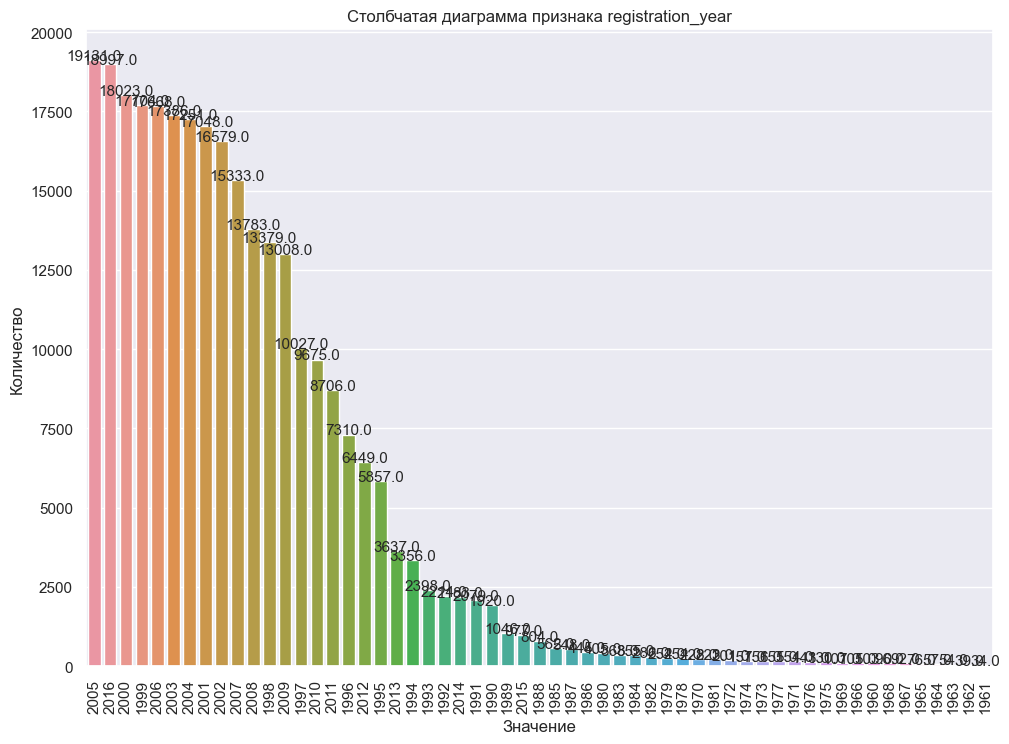

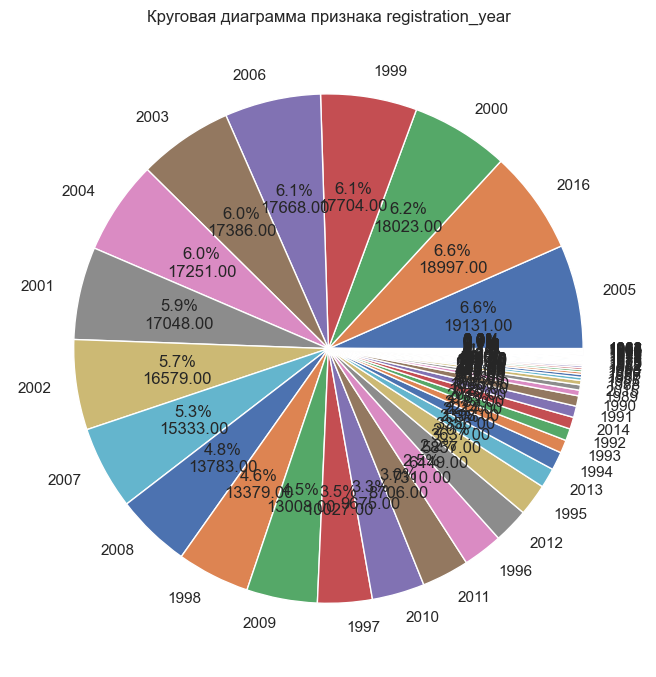

In [51]:
print_pie_bar(df['registration_year'].to_frame())

Чуть перестроим пайплот:

count     289715
unique        18
top          old
freq       73881
Name: registration_year, dtype: object


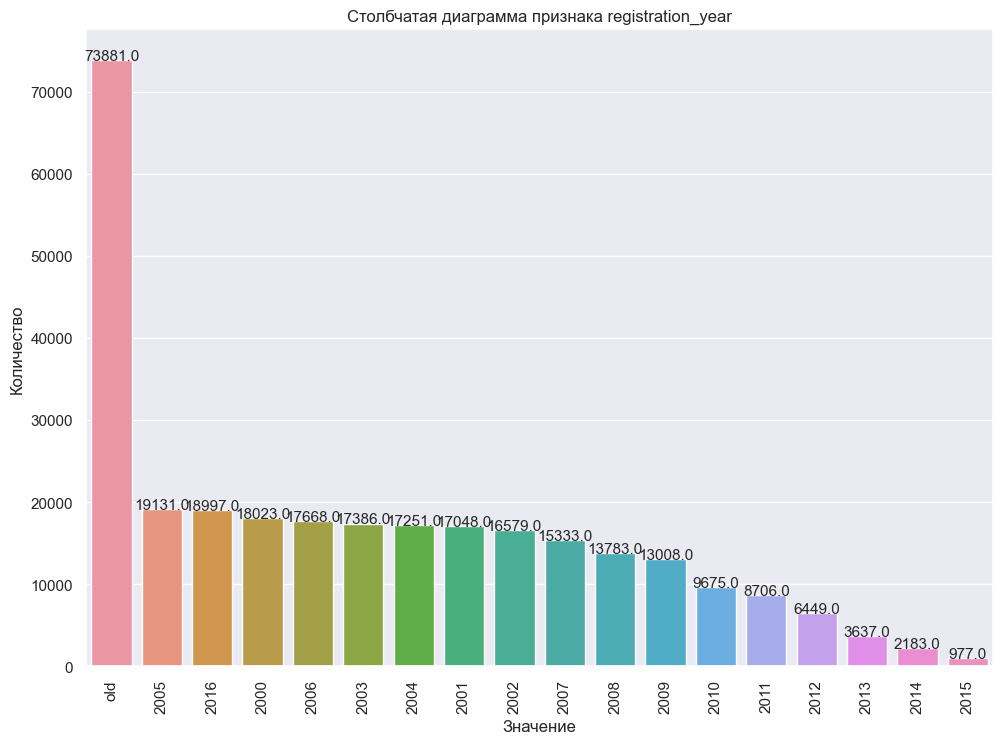

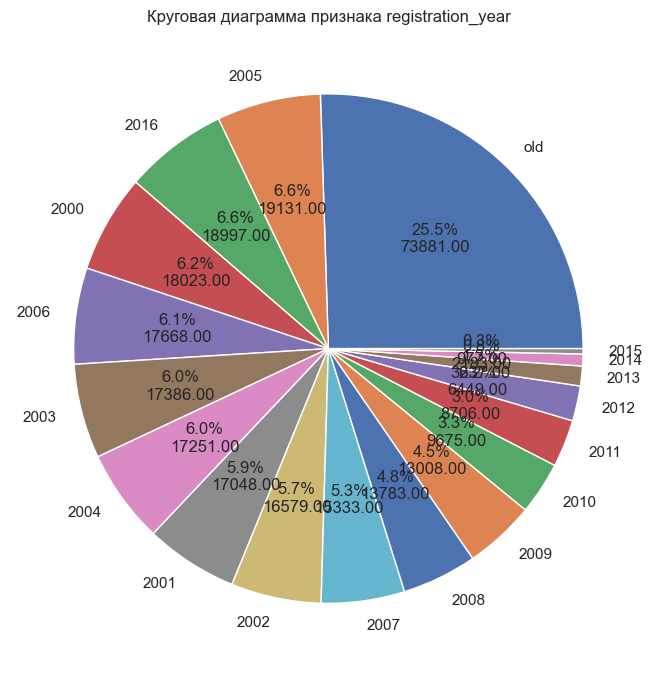

In [52]:
tmp = df['registration_year'].apply(lambda x: 'old' if x < 2000 else x)
print_pie_bar(tmp.to_frame())

На рынке представлено порядка 25% старых автомобилей, что ожидаемо. Объединение можно было бы не делать, но так читаемее

По моделям нет смысла что-то перестраивать, если только взять и построить топ 10 продаваемых моделей

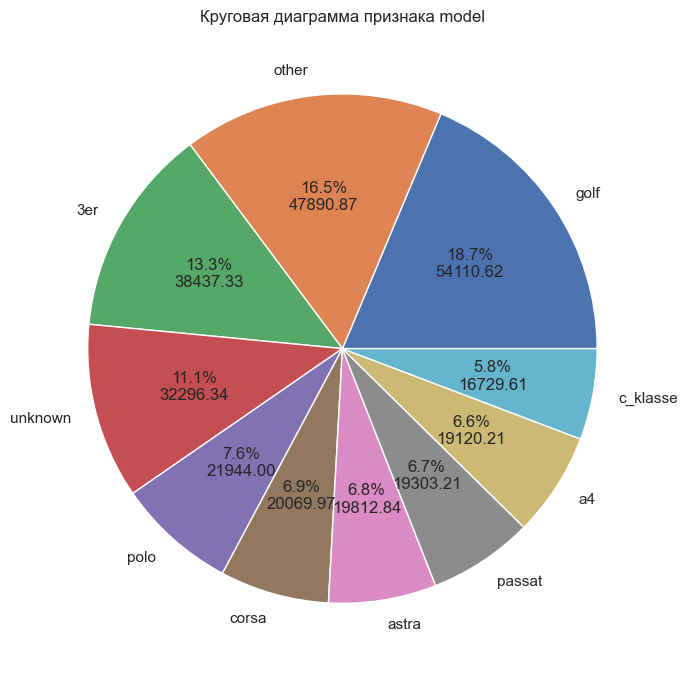

In [53]:
total = df['model'].count()
df['model'].value_counts().head(10).plot(kind='pie', autopct=fmt)
plt.title('Круговая диаграмма признака model')
plt.ylabel('')
plt.show()

- тип топлива - `fuel_type` все нормально, без неожиданностей - в основном бензин или газ
- тип коробки передач тоже без сюрпризов - в основном на механике
- по брендам тоже, но явный лидер рынка - фольцваген
- основная часть машин в ремонте не была
- присутствует нулевой месяц, что странно, скорее всего это заглушка на случай отстутсвия месяца в объявлении оставим пока так

Я постарался сохранить максимальное количество данных с минимальными искажениями... Надеюсь получилось)

### Корреляционный анализ данных

Распределения признаков нормальным не является, так что сразу построим `Фk`

In [54]:
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
1 2016-03-24 10:58:45  18300        coupe               2011  manual  190.0   
2 2016-03-14 12:52:21   9800          suv               2004    auto  163.0   
3 2016-03-17 16:54:04   1500        small               2001  manual   75.0   
4 2016-03-31 17:25:20   3600        small               2008  manual   69.0   
5 2016-04-04 17:36:23    650        sedan               1995  manual  102.0   

     model  kilometer  registration_month fuel_type       brand repaired  \
1  unknown     125000                   3    petrol        audi      yes   
2    grand     125000                   3    petrol        jeep       no   
3     golf     150000                   3    petrol  volkswagen       no   
4    fabia      90000                   3    petrol       skoda       no   
5      3er     150000                   4    petrol         bmw      yes   

  date_created  number_of_pictures  postal_code           last_seen  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21  
5   2016-04-04                   0        33775 2016-04-06 19:17:07

В корреляционном анализе также не будем учитывать даты (удалим эти признаки в следующем пункте), почтовый индекс (`postal_code`), потому что он никак не характеризует авто

In [55]:
interval_columns = df.select_dtypes(include='number').drop(columns=['registration_year', 'registration_month', 'postal_code']).columns

C:\Users\Maxim\anaconda3\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable number_of_pictures for analysis 1. Dropping this column
  warnings.warn(


Text(0.5, 1.0, 'корреляция $\\phi_K$')

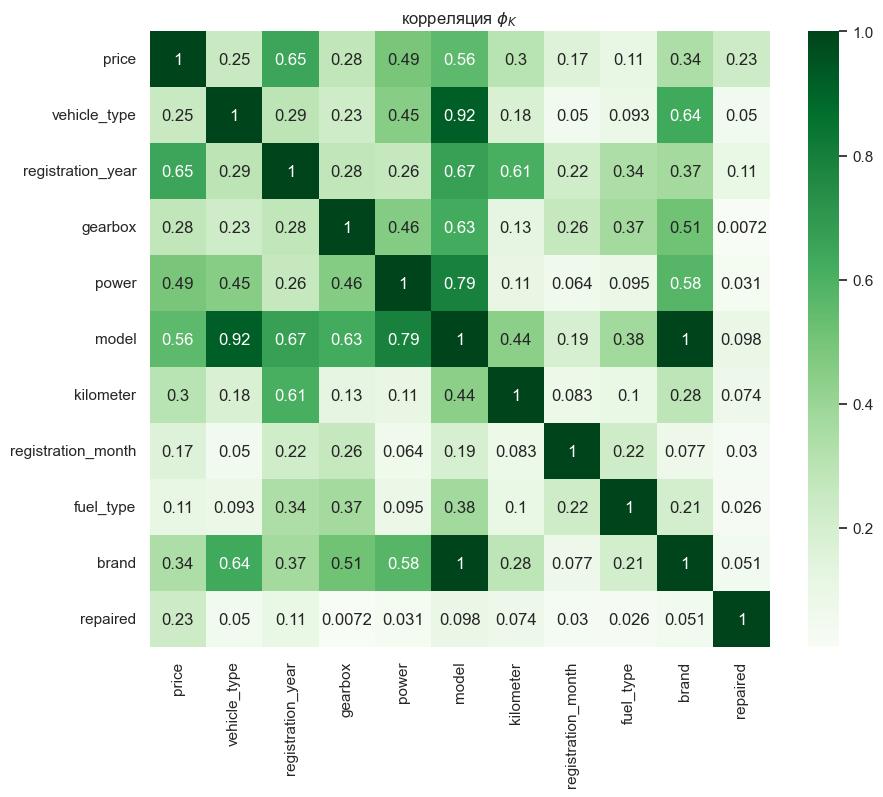

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['date_crawled', 'last_seen', 'postal_code', 'date_created']).phik_matrix(interval_cols=interval_columns), annot=True, cmap='Greens')
plt.title(r'корреляция $\phi_K$')

Видим мультиколлинеарные признаки - модель и тип кузова - логично, потому что часто у одной модели только один кузов. Сделаем 2 датасета - один без мультиколлинеарности (для линейных моделей), другой с ней для дерева и бустинга. В целом, по матрице корреляций можем сделать вывод о том, чтл сильнее всего влияет год регистрации, модель и мощность двигателя, что соответствует действительности

In [57]:
df_linear = df.drop(columns=['vehicle_type']).copy()
df_linear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289715 entries, 1 to 323182
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        289715 non-null  datetime64[ns]
 1   price               289715 non-null  int64         
 2   registration_year   289715 non-null  int64         
 3   gearbox             289715 non-null  object        
 4   power               289715 non-null  float64       
 5   model               289715 non-null  object        
 6   kilometer           289715 non-null  int64         
 7   registration_month  289715 non-null  int64         
 8   fuel_type           289715 non-null  object        
 9   brand               289715 non-null  object        
 10  repaired            289715 non-null  object        
 11  date_created        289715 non-null  datetime64[ns]
 12  number_of_pictures  289715 non-null  int64         
 13  postal_code         289715 non-nul

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289715 entries, 1 to 323182
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        289715 non-null  datetime64[ns]
 1   price               289715 non-null  int64         
 2   vehicle_type        289715 non-null  object        
 3   registration_year   289715 non-null  int64         
 4   gearbox             289715 non-null  object        
 5   power               289715 non-null  float64       
 6   model               289715 non-null  object        
 7   kilometer           289715 non-null  int64         
 8   registration_month  289715 non-null  int64         
 9   fuel_type           289715 non-null  object        
 10  brand               289715 non-null  object        
 11  repaired            289715 non-null  object        
 12  date_created        289715 non-null  datetime64[ns]
 13  number_of_pictures  289715 non-nul

Попробуем посмотрить на скаттерплоты зависимости таргета от признаков

C:\Users\Maxim\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


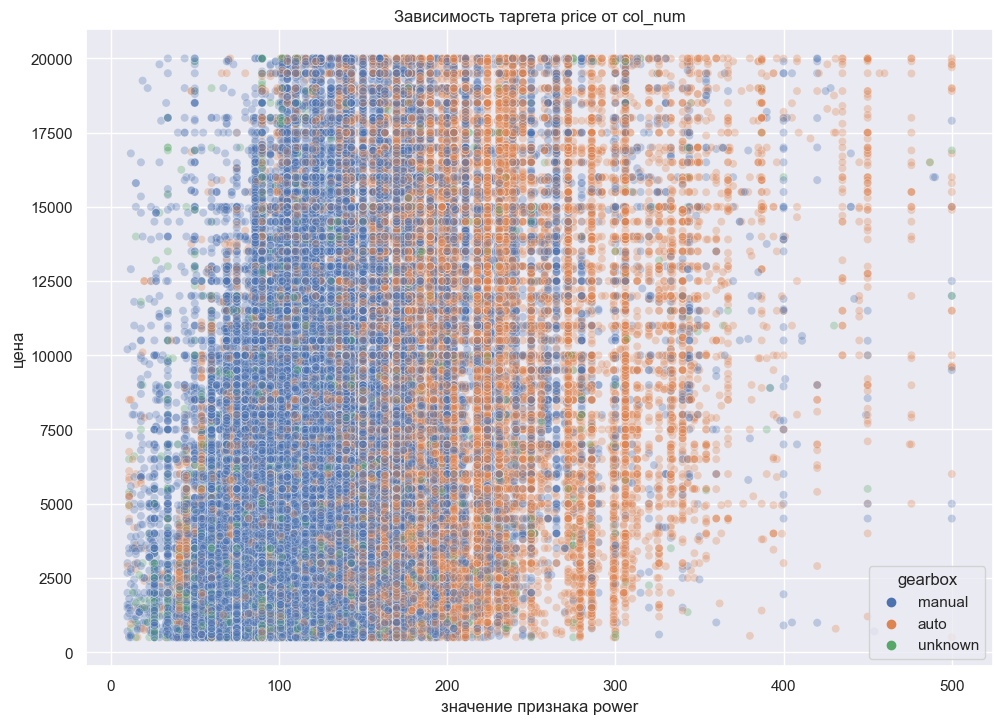

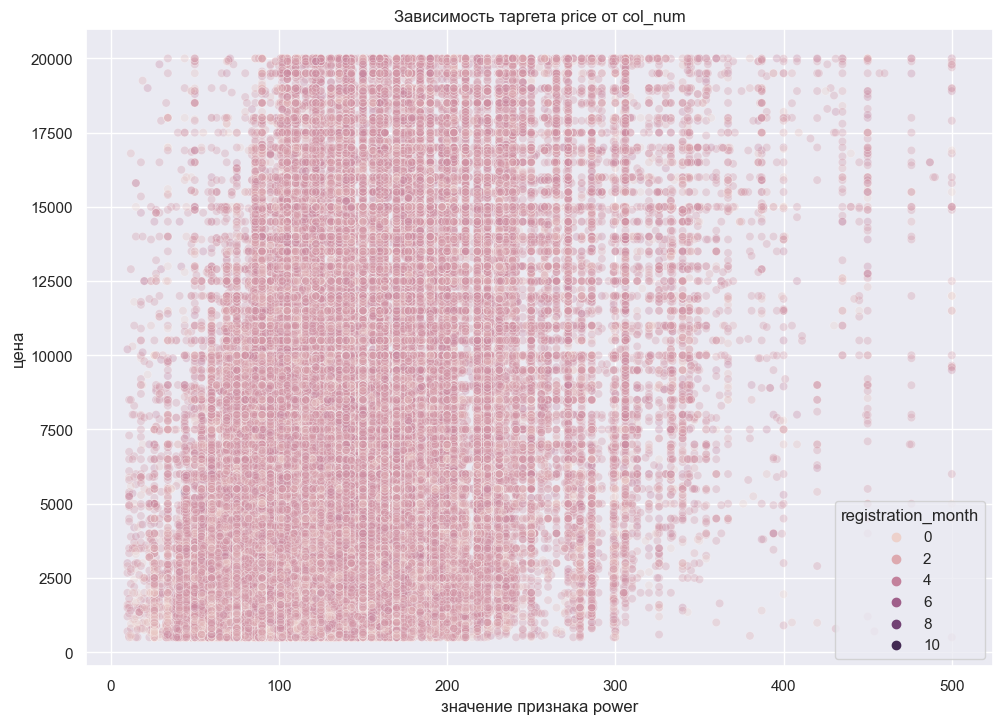

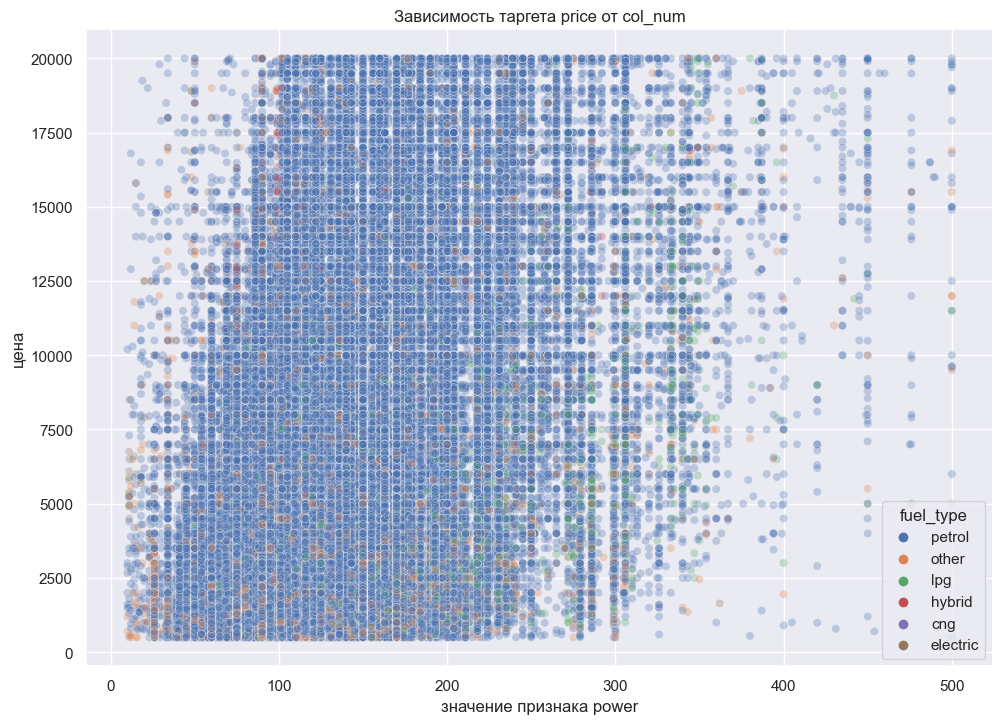

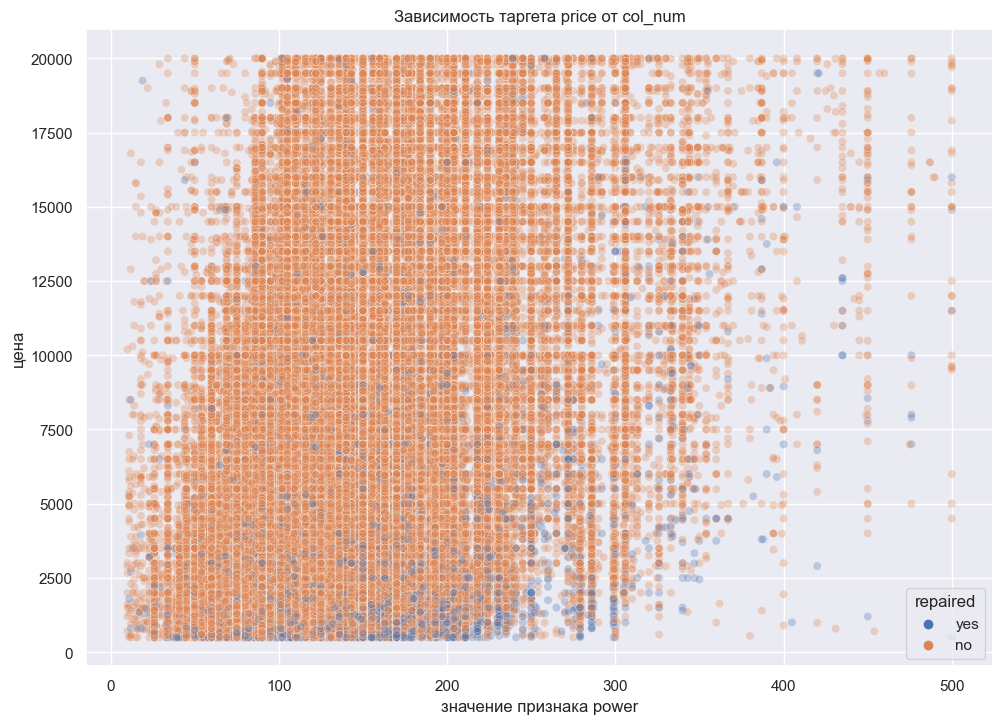

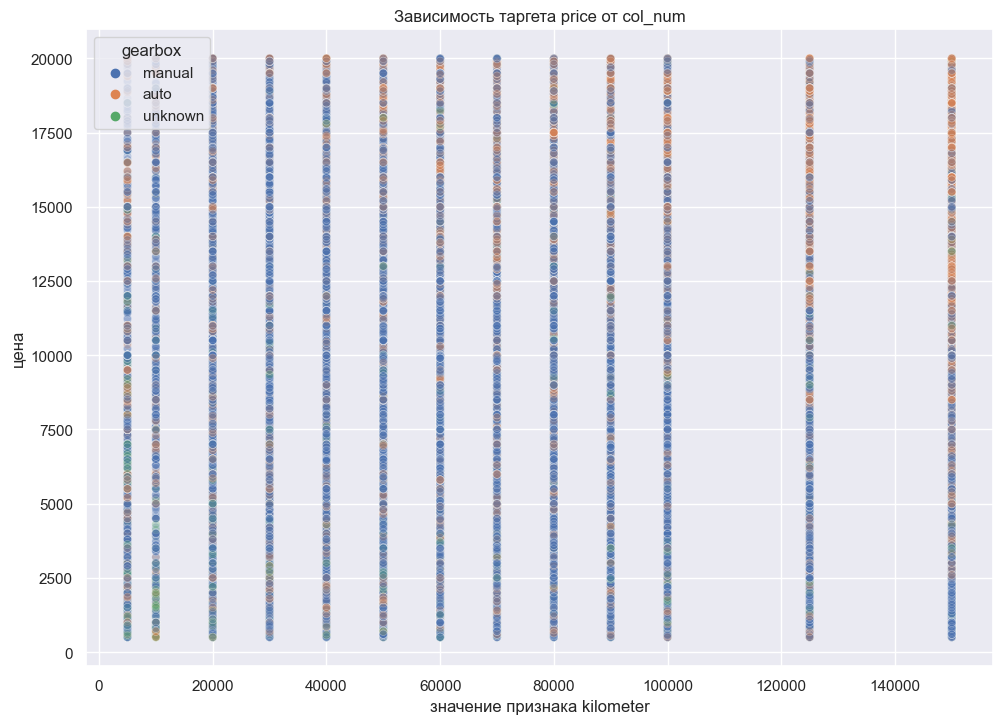

C:\Users\Maxim\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


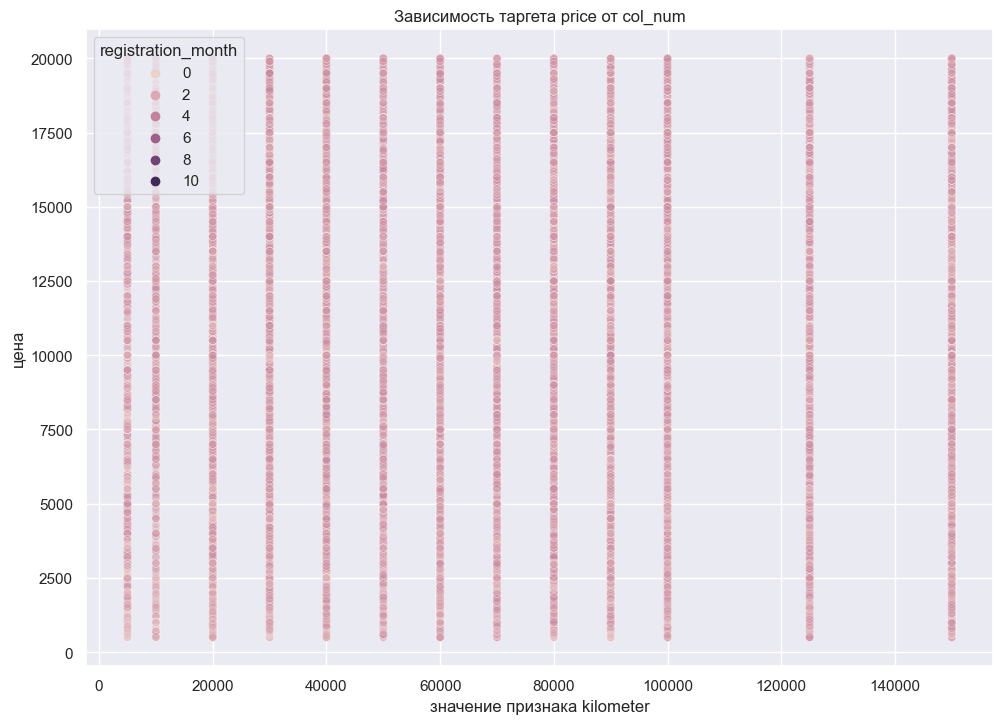

C:\Users\Maxim\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


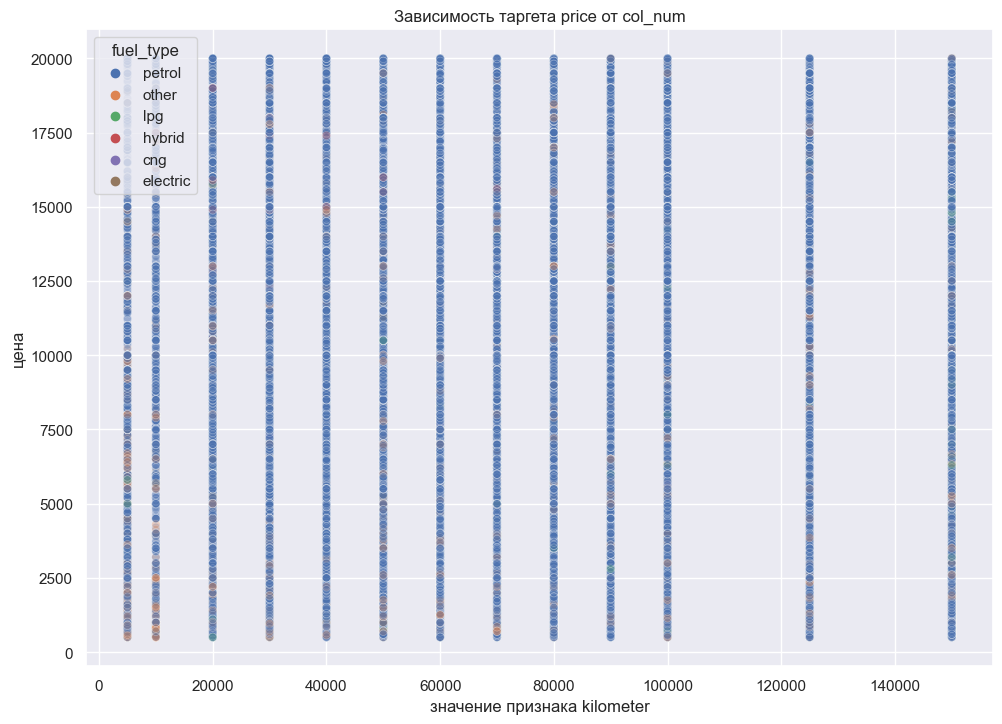

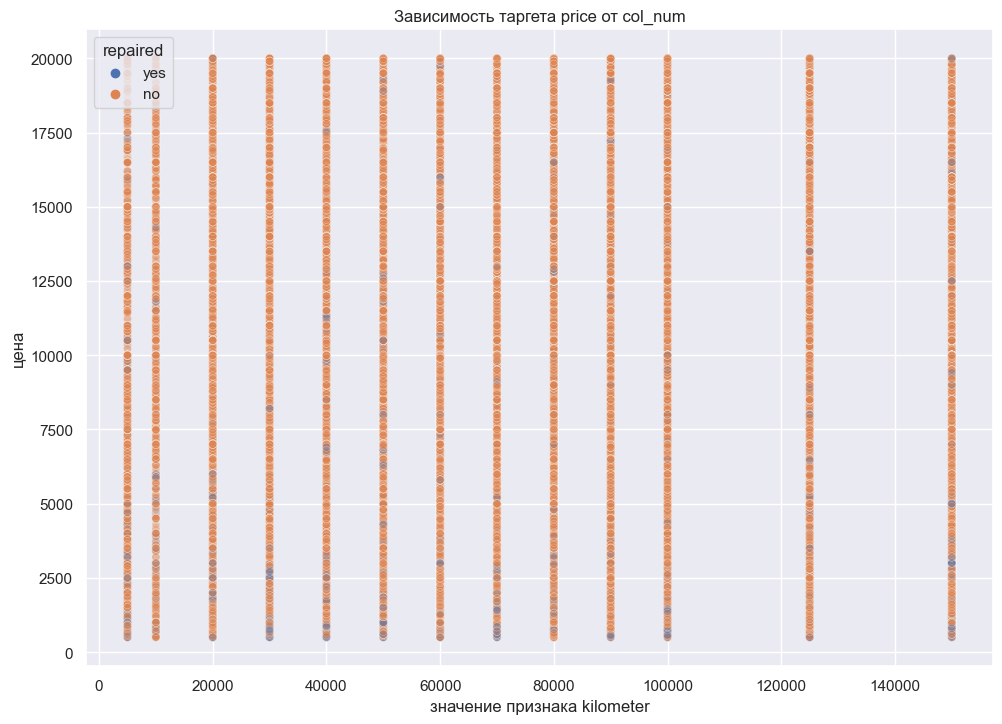

In [59]:
for col_num in df.drop(columns=['registration_year', 'registration_month', 'postal_code', 'price', 'number_of_pictures']).select_dtypes(include='number').columns:
    for col_cat in df[['gearbox', 'registration_month', 'fuel_type', 'repaired']].columns:
        ax = sns.scatterplot(data=df, x=col_num, y='price', hue=col_cat, alpha=0.3)
        plt.title('Зависимость таргета price от ' + 'col_num')
        plt.ylabel('цена')
        plt.xlabel('значение признака ' + col_num)
        plt.show()

Построенные скаттер плоты подтверждают маьрицу корреляций, из интресного можно заметить, что основая масса автомобилей с максимальным пробегом - на газе. Это особо не относится к исследованию моделей, но все же интресно

**Вывод по пункту**
- на этапе предобработки было сделано:
    1. поработали с именами столбцов
    2. обработаны пропуски
    3. проведена работа с типами данных
- на этапе исследовательского анализа данных
    1. обработаны выбросы
    2. изучены распределения признаков
- на этапе корреляционного анализа было сделано
    1. установлены зависимости с таргетом

## Обучение моделей <a id='models_train'>

### Feature engeneering

Начнем с того что подропаем неинофрмативные признаки

Повторим причину дропа каждого признака:
- дата скачивания, дата создания анкеты и дата последней активности однозначно никак не определяют автомобиль, ровно как и индекс владельца
- количество фотографий везде 0, так что тоже не имеет смысла 

In [60]:
df = df.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289715 entries, 1 to 323182
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               289715 non-null  int64  
 1   vehicle_type        289715 non-null  object 
 2   registration_year   289715 non-null  int64  
 3   gearbox             289715 non-null  object 
 4   power               289715 non-null  float64
 5   model               289715 non-null  object 
 6   kilometer           289715 non-null  int64  
 7   registration_month  289715 non-null  int64  
 8   fuel_type           289715 non-null  object 
 9   brand               289715 non-null  object 
 10  repaired            289715 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 26.5+ MB


In [61]:
df_linear = df_linear.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created'])
df_linear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289715 entries, 1 to 323182
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               289715 non-null  int64  
 1   registration_year   289715 non-null  int64  
 2   gearbox             289715 non-null  object 
 3   power               289715 non-null  float64
 4   model               289715 non-null  object 
 5   kilometer           289715 non-null  int64  
 6   registration_month  289715 non-null  int64  
 7   fuel_type           289715 non-null  object 
 8   brand               289715 non-null  object 
 9   repaired            289715 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 24.3+ MB


После проведния масштабного анализа данных, устранения аномалий и удалений признаков, можно еще раз проверить данные на дубликаты.

In [62]:
df.duplicated().sum()

12125

In [63]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Как и было сказано для задач регрессии, кто бы что ни говорил, а таргету лучше быть нормально распределенным.<br>
**UPD**: видимо из за выбросов или еще по какой то причине, в данной задаче модель предсказывает точнее без логарифмирования таргета


count    277590.000000
mean       4973.119702
std        4563.949606
min         500.000000
25%        1500.000000
50%        3300.000000
75%        6999.000000
max       20000.000000
Name: price, dtype: float64


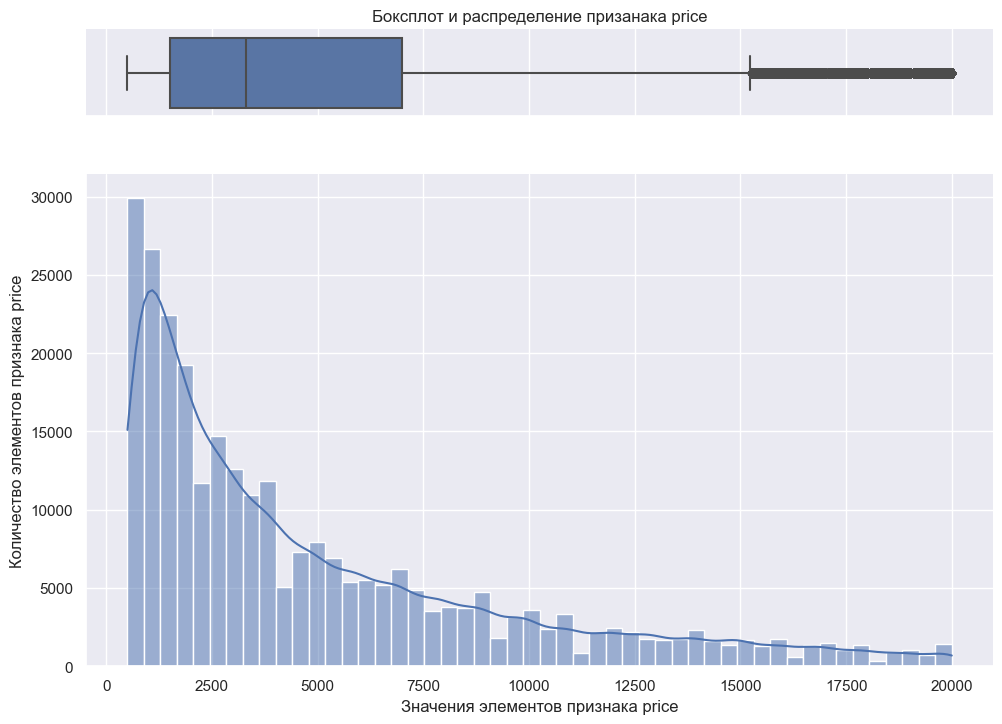

In [64]:
print_hist_box(df['price'].to_frame())

### Подготовка моделей и обучение моделей

Подготовим пайплайны и обучим модели

In [65]:
df.head()

price vehicle_type  registration_year gearbox  power    model  kilometer  \
0  18300        coupe               2011  manual  190.0  unknown     125000   
1   9800          suv               2004    auto  163.0    grand     125000   
2   1500        small               2001  manual   75.0     golf     150000   
3   3600        small               2008  manual   69.0    fabia      90000   
4    650        sedan               1995  manual  102.0      3er     150000   

   registration_month fuel_type       brand repaired  
0                   3    petrol        audi      yes  
1                   3    petrol        jeep       no  
2                   3    petrol  volkswagen       no  
3                   3    petrol       skoda       no  
4                   4    petrol         bmw      yes

In [66]:
ohe_cols = ['repaired', 'gearbox', 'fuel_type']
ord_cols_linear = ['model', 'registration_year', 'brand', 'kilometer']
ord_cols = ord_cols_linear + ['vehicle_type']
num_cols = df.select_dtypes(include='number').drop(columns=['registration_year', 'kilometer', 'price']).columns # just power =)

#### Бустинг и дерево

In [67]:
ohe_pl = Pipeline(
    [
        ('ohe_imp', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

ord_pl = Pipeline( # we use ordinal here because of big variety of each feature
    [
        ('ord_imp', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('ord_imp_post', SimpleImputer(strategy='most_frequent', missing_values=np.nan))
    ]
)

col_transformer = ColumnTransformer(
    [
        ('ohe', ohe_pl, ohe_cols),
        ('ord', ord_pl, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [68]:
final_pl = Pipeline(
    [
        ('prep', col_transformer),
        ('models', LinearRegression())
    ]
)

In [69]:
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

Попробуем обучить модели линейной регрессии, решащего деререва и 3-х различных реализаций градиентного бустинга: 
- `CatBoostRegressor`
- `LGBMRegressor`
- `XGBRegressor`
Для каждого подберем гиперпараметры с помощью нескольких запусков `GridSearchCV`<br>
Тут тоже подбираем гиперпараметры. Почему такие параметры: например для max_depth: я изначально делаю range(2, 10), потом, если вижу, что значение лучшей модели упирается вправо, то увеличиваю правую границу, и так запускаю пайплайн и GridSearchCV много раз, при этом слежу, чтобы модель не переобучилась. Отсюда и такие значения

Ну и соответсвенно для линейной регрессии и оставшихся моделей придется создать разные пайплайны. 

In [70]:
params = [
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, cat_features=ord_cols + ohe_cols, verbose=100)],
        'models__learning_rate':  [0.1, 0.2], 
        'models__max_depth': [7, 9],
        'models__n_estimators': [500], 
        'models__subsample': [0.6],
        'prep': ['passthrough']
    },
    {
        'models': [XGBRegressor(random_state=RANDOM_STATE), LGBMRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate':  [0.1, 0.2],
        'models__max_depth': [7, 9],
        'models__n_estimators': [500],
        'models__subsample': [0.6],
        'prep__num': ['passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 5),
        'models__min_samples_split': range(3, 5),
        'models__min_samples_leaf': range(3, 5),
        'prep__num': ['passthrough']
    }
]

In [71]:
search = GridSearchCV(
    final_pl,
    param_grid=params,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

In [72]:
search.fit(X_train, y_train)

0:	learn: 3913.4638985	total: 282ms	remaining: 2m 20s
100:	learn: 1670.5269458	total: 13.6s	remaining: 53.7s
200:	learn: 1592.3126436	total: 26.8s	remaining: 39.9s
300:	learn: 1540.6186180	total: 41s	remaining: 27.1s
400:	learn: 1503.7990583	total: 54.6s	remaining: 13.5s
499:	learn: 1473.2064839	total: 1m 8s	remaining: 0us


GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe_imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['repaired',
                                                                          'gearbox',
                                                                          'fuel_type']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord_imp',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                          'models__learning_rate': [0.1, 0.2],
                          'models__max_depth': [7, 9],
                          'models__n_estimators': [500],
                          'models__subsample': [0.6],
                          'prep__num': ['passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(3, 5),
                          'models__min_samples_leaf': range(3, 5),
                          'models__min_samples_split': range(3, 5),
                          'prep__num': ['passthrough']}],
             scoring='neg_root_mean_squared_error')

In [73]:
search.best_estimator_

Pipeline(steps=[('prep', 'passthrough'),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x000001CD2F1C9590>)])

In [74]:
np.abs(search.best_score_)

1686.4042540556645

In [75]:
search.best_params_

{'models': <catboost.core.CatBoostRegressor at 0x1cd35a01dd0>,
 'models__learning_rate': 0.2,
 'models__max_depth': 9,
 'models__n_estimators': 500,
 'models__subsample': 0.6,
 'prep': 'passthrough'}

#### Линейная регрессия

Теперь посмотрим на то, как с задачей справятся линейные модели

In [76]:
X_linear = df_linear.drop(columns=['price'])
y_linear = df_linear['price']
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, random_state=RANDOM_STATE)

In [77]:
col_transformer = ColumnTransformer(
    [
        ('ohe', ohe_pl, ohe_cols),
        ('ord', ord_pl, ord_cols_linear),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [78]:
final_pl_linear = Pipeline(
    [
        ('prep', col_transformer),
        ('models', LinearRegression())
    ]
)

In [79]:
params_linear = [
    {
        'models': [Ridge(random_state=RANDOM_STATE), Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 0.5, 1, 2],
    },
    {
        'models': [LinearRegression()]
    }
]

In [80]:
search_linear = GridSearchCV(
    final_pl_linear,
    param_grid=params_linear,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

In [81]:
search_linear.fit(X_train_linear, y_train_linear)

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe_imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['repaired',
                                                                          'gearbox',
                                                                          'fuel_type']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord_imp',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['model',
                                                                          'registration_year',
                                                                          'brand',
                                                                          'kilometer']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['power', 'registration_month'], dtype='object'))])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [Ridge(random_state=42),
                                     Lasso(random_state=42)],
                          'models__alpha': [0.1, 0.5, 1, 2]},
                         {'models': [LinearRegression()]}],
             scoring='neg_root_mean_squared_error')

In [82]:
np.abs(search_linear.best_score_)

3195.2506271255006

Как видим, бустинг справляется с явным отрывом

### Вывод по пункту

На кросс валидации получаем RMSE = 1686.4. На самом деле это немало с учетом того, что у нас цены на автомобиль достигают максимум 20000. Думаю, что проблема как раз в данных. Что много странных объявлений, и даже несмотря на то, что большую часть почистили, все равно остались странные объявления, а также не хвататает других характреристик

**Вывод по пукту**
- были подготовлены пайплайны для обучения
- были обучены:
- модель линейной регрессии
- модель решащего деререва
- 3-х различных реализаций гградиентного бустинга: 
    1. `CatBoostRegressor`
    2. `LGBMRegressor`
    3. `XGBRegressor`<br>
Для каждого подобраны гиперпараметры с помощью нескольких запусков `GridSearchCV`<br>
Лучшей стала модель `CatBoostRegressor` со значением метрики 1686.4 при кросс валидации.

## Анализ моделей <a id='model_analize'>

Итак, в прошлом пункте мы получили лучшую модель по метрике - `XGBRegressor`. Посмотрим теперь на другие необзодимые параметры моделей, необходимые заказчику - время обучения и время предсказания. Будем сравнивать лучшие модели по качеству:

In [83]:
pd.DataFrame(search.cv_results_).\
                                sort_values(by='mean_test_score', ascending=False)\
                                        [['mean_fit_time', 'std_fit_time', 'mean_score_time',	'std_score_time', 'param_models', 'mean_test_score', 'std_test_score']]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3      334.111707    113.307177         0.480914        0.074434   
11      30.591402      2.367052         0.709930        0.144207   
10      71.554471     42.740585         0.500861        0.053883   
4       35.492498      2.029703         2.933756        0.706011   
5       46.960633      4.304858         3.962803        0.167691   
1      549.127991      8.070734         0.689756        0.119755   
9      131.346394     10.341569         0.669609        0.125979   
8      147.470280      9.595887         0.809036        0.187975   
2      440.276518     18.201139         1.081708        0.317549   
6       35.553734      3.304349         2.611018        0.294958   
0      431.352636     16.845710         1.240284        0.518650   
7       42.914252      1.925264         3.221985        0.207335   
16       2.384025      0.024189         0.316953        0.051520   
17       2.389810      0.052476         0.292418        0.017405   
18       2.292271      0.016432         0.296607        0.024886   
19       2.094799      0.277725         0.212232        0.038557   
12       1.691477      0.176606         0.259107        0.072424   
13       2.349318      0.103077         0.281049        0.050860   
14       1.881569      0.030030         0.265091        0.017789   
15       2.075251      0.156666         0.285237        0.013675   

                                         param_models  mean_test_score  \
3   <catboost.core.CatBoostRegressor object at 0x0...     -1686.404254   
11                     LGBMRegressor(random_state=42)     -1686.794844   
10                     LGBMRegressor(random_state=42)     -1686.962699   
4   XGBRegressor(base_score=None, booster=None, ca...     -1687.320708   
5   XGBRegressor(base_score=None, booster=None, ca...     -1689.127766   
1   <catboost.core.CatBoostRegressor object at 0x0...     -1697.310033   
9                      LGBMRegressor(random_state=42)     -1700.629511   
8                      LGBMRegressor(random_state=42)     -1705.943031   
2   <catboost.core.CatBoostRegressor object at 0x0...     -1706.199186   
6   XGBRegressor(base_score=None, booster=None, ca...     -1710.642887   
0   <catboost.core.CatBoostRegressor object at 0x0...     -1726.355039   
7   XGBRegressor(base_score=None, booster=None, ca...     -1739.051131   
16             DecisionTreeRegressor(random_state=42)     -2775.708480   
17             DecisionTreeRegressor(random_state=42)     -2775.708480   
18             DecisionTreeRegressor(random_state=42)     -2775.708480   
19             DecisionTreeRegressor(random_state=42)     -2775.708480   
12             DecisionTreeRegressor(random_state=42)     -3078.449037   
13             DecisionTreeRegressor(random_state=42)     -3078.449037   
14             DecisionTreeRegressor(random_state=42)     -3078.449037   
15             DecisionTreeRegressor(random_state=42)     -3078.449037   

    std_test_score  
3         2.728665  
11        6.651305  
10        5.637834  
4         7.052145  
5         8.625721  
1         4.573720  
9         4.652339  
8         5.140867  
2         2.034028  
6         8.940031  
0         2.196729  
7         9.727837  
16        6.411538  
17        6.411538  
18        6.411538  
19        6.411538  
12        8.848991  
13        8.848991  
14        8.848991  
15        8.848991

Видим, что наша лучшая модель по скору медленнее всего обучается и быстрее всего предсказывает (среди бустингов). Стоит отметить и то, что все 3 имплементации бустига могут подойти, и если заказчику важно время обучения, то лучше взять, конечно, `XGBoost`. Но остановимся мы именно на `CatBoost`, потому что эта модель имеет ряд преимуществ, например, то, что просто из коробки она будет наиболее точной. Перепроверим данные о скорости обучения и предсказания у нашей луйшей модели

In [84]:
%%time
search.best_estimator_.fit(X_train, y_train)

0:	learn: 3913.4638985	total: 109ms	remaining: 54.2s
100:	learn: 1670.5269458	total: 12.6s	remaining: 49.7s
200:	learn: 1592.3126436	total: 25.5s	remaining: 37.9s
300:	learn: 1540.6186180	total: 39.1s	remaining: 25.8s
400:	learn: 1503.7990583	total: 52.9s	remaining: 13.1s
499:	learn: 1473.2064839	total: 1m 5s	remaining: 0us
CPU times: total: 42.6 s
Wall time: 1min 6s


Pipeline(steps=[('prep', 'passthrough'),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x000001CD2F1C9590>)])

In [85]:
%%time
search.best_estimator_.predict(X_test)

CPU times: total: 1.48 s
Wall time: 280 ms


array([ 6990.55414429,  3425.57212621,  8608.55199744, ...,
       10356.11346996,  1450.10221584,  3993.71523731])

Обучение занимает ~ 37 секунд процессорного времени и ~ 1.1 минуты "настенного времени", то есть часы, находящиеся за пределами ПК посчитают 1.1 минуты.<br>
Предсказание занимает ~ 1.28 процессорного времени и ~ 250 мс "настенного времени"

ну и выполним еще раз предсказание на тестовой выборке и посчитаем RMSE:

In [86]:
root_mean_squared_error(y_test, search.predict(X_test))

1689.9939650633469

Видим небольшое переобучение, но на кросс-валидации это допустимо

На всякий случай проверим нашу модель на адекватность и сделаем прогноз Дамми регрессором.

In [87]:
dummy_pl = Pipeline(
    [
        ('prep', col_transformer),
        ('models', DummyRegressor())
    ]
)
dummy_pl.fit(X_train, y_train)
root_mean_squared_error(y_test, dummy_pl.predict(X_test))

4579.7435214959105

Наша модель намного лучше

## Вывод <a id='conclusion'>

В данном проекте были проанализированы данные об анкетах о продаже авто.<br>
- на этапе предобработки было сделано:
    1. поработали с именами столбцов
    2. обработаны пропуски
    3. проведена работа с типами данных
- на этапе исследовательского анализа данных
    1. обработаны выбросы
    2. изучены распределения признаков
- на этапе корреляционного анализа было сделано
    1. установлены зависимости с таргетом
- на этапе подготовки данных к обучению было сделано:
    - были подготовлены пайплайны для обучения
    - были обучены:
    - модель линейной регрессии
    - модель решащего деререва
    - 3-х различных реализаций гградиентного бустинга: 
        1. `CatBoostRegressor`
        2. `LGBMRegressor`
        3. `XGBRegressor`<br>
Для каждого подобраны гиперпараметры с помощью нескольких запусков `GridSearchCV`<br>
Лучшей по скору стала модель `CatBoostRegressor` со значением метрики 1690.0 на тестовой выборке.
Проанализировав и другие модели, мы поняли, что оптимальным решением для заказчика станет как раз наша лучшая модель с результатми:
- Обучение занимает ~ 37 секунд процессорного времени и ~ 1.1 минуты "настенного времени", то есть часы, находящиеся за пределами ПК посчитают 1.1 минуты.<br>
- Предсказание занимает ~ 1.28 процессорного времени и ~ 250 мс "настенного времени"<br>
**Рекомендации**
- Если заказчику нужна скорость обучения, то рекомендуется использовать модель `XGBoost`.
- Если время предсказания важна критически, то `CatBoost`.
- Для повышения качества предсказания рекомендации рекомендуем:
    1. Класс авто (бизнес, спорт, ретро и т.д.). Это позволит смотреть на цены объективнее. И предсказывать цену правильнее будет в каждой конкретной категории (если нужно предсказать модель авто из нужного класса, то просто берем модель, обученную на определенном классе)
    2. В идеале поработать с базой, потому что очень много аномалий в данных. 